In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams['figure.dpi'] = 150
import seaborn as sns
import scipy.stats as st
import statsmodels
import statsmodels.api as sm
from functools import reduce

import glob, os, yaml, subprocess, itertools, sparse, sys, statsmodels, shutil
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

analysis_dir = '/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue'

lineages = pd.read_csv("../lineages/combined_lineages_samples.csv")
print(lineages.shape)
import collections, warnings
warnings.filterwarnings("ignore")

sys.path.append(os.path.join(os.path.dirname(os.getcwd()), "utils"))
from stats_utils import *
from data_utils import *

coll2014 = pd.read_csv("../data/coll2014_SNP_scheme.tsv", sep="\t")
coll2014["#lineage"] = coll2014["#lineage"].str.replace("lineage", "")
coll2014.rename(columns={"#lineage": "Lineage"}, inplace=True)
coll2014['nucleotide'] = [val.split('/')[1] for val in coll2014['allele_change'].values]

drug_abbr_dict = {"Delamanid": "DLM",
                  "Bedaquiline": "BDQ",
                  "Clofazimine": "CFZ",
                  "Ethionamide": "ETO",
                  "Linezolid": "LZD",
                  "Moxifloxacin": "MXF",
                  "Capreomycin": "CAP",
                  "Amikacin": "AMK",
                  "Pretomanid": "PMD",
                  "Pyrazinamide": "PZA",
                  "Kanamycin": "KAN",
                  "Levofloxacin": "LFX",
                  "Streptomycin": "STM",
                  "Ethambutol": "EMB",
                  "Isoniazid": "INH",
                  "Rifampicin": "RIF"
                 }

cc_df = pd.read_csv("../data/drug_CC.csv")
who_variants_V1 = pd.read_excel("../results/WHO-catalog-V1.xlsx", sheet_name='Mutation_catalogue')
who_variants = pd.read_csv("../results/WHO-catalog-V2-tier1.csv")

# need WHO and ALL prefixes for this
# who_variants['PPV_lb_clean'] = who_variants['PPV_lb'].str.replace('%', '').astype(float)
# who_variants['PPV_ub_clean'] = who_variants['PPV_ub'].str.replace('%', '').astype(float)

results_final = pd.read_csv("../results/Regression_Final_June2024_Tier1.csv")
drug_gene_mapping = pd.read_csv("../data/drug_gene_mapping.csv")
silent_lst = ['synonymous_variant', 'initiator_codon_variant', 'stop_retained_variant']

solo_binary_stats = pd.read_csv("../results/solo_binary_stats_Aug2023.csv")
solo_binary_stats["Model"] = "SOLO"
solo_binary_stats = solo_binary_stats.set_index("Model")

drugs_lst = list(drug_abbr_dict.keys())

metrics_components_dict = {'Sens': ['TP', 'FN'],
                           'Spec': ['TN', 'FP'],
                           'F1': [None, None],
                           'PPV': ['TP', 'FP'],
                           'NPV': ['TN', 'FN`']
                          }

sample_ids_mapping = pd.read_csv("../data/sample_ids_mapping_20220922.csv")

silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']
lof_lst = ["frameshift", "start_lost", "stop_gained", "feature_ablation"]

(52567, 10)


In [10]:
results_final.loc[(results_final['Initial confidence grading WHO dataset']=='Uncertain') & (results_final['Initial confidence grading ALL dataset']=='Assoc w R') & (~results_final['predicted_effect'].isin(lof_lst))]['SOLO INITIAL CONFIDENCE GRADING'].value_counts()

SOLO INITIAL CONFIDENCE GRADING
3) Uncertain significance    92
1) Assoc w R                 19
2) Assoc w R - Interim        5
5) Not assoc w R              1
Name: count, dtype: int64

In [11]:
len(results_final.loc[(results_final['Initial confidence grading WHO dataset']=='Uncertain') & (results_final['Initial confidence grading ALL dataset']=='Assoc w R') & (~results_final['predicted_effect'].isin(lof_lst))])

117

In [15]:
results_final.loc[(results_final['Initial confidence grading WHO dataset']=='Uncertain') & (results_final['Initial confidence grading ALL dataset']=='Assoc w R') & (~results_final['predicted_effect'].isin(lof_lst))]['SOLO FINAL CONFIDENCE GRADING'].value_counts()

SOLO FINAL CONFIDENCE GRADING
3) Uncertain significance    82
2) Assoc w R - Interim       34
5) Not assoc w R              1
Name: count, dtype: int64

In [19]:
# results_final.loc[(results_final['Initial confidence grading WHO dataset']=='Uncertain') & (results_final['Initial confidence grading ALL dataset']=='Assoc w R') & (~results_final['predicted_effect'].isin(lof_lst)) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))]

# Read MIC results into a table

In [55]:
# MIC_results = []

# for drug in drugs_lst:

#     if drug != 'Pretomanid':
        
#         for model_path in ["dropAF_noSyn_unpooled", "dropAF_noSyn_poolLoF", "dropAF_withSyn_unpooled"]:
    
#             model_analysis_fName = f"{analysis_dir}/{drug}/MIC/tiers=1/{model_path}/model_analysis.csv"
#             model_matrix_fName = f"{analysis_dir}/{drug}/MIC/tiers=1/{model_path}/model_matrix.pkl"
            
#             if os.path.isfile(model_analysis_fName):
#                 df = pd.read_csv(model_analysis_fName)
#                 df['Drug'] = drug
    
#                 # model_matrix = pd.read_pickle(model_matrix_fName)
                
#                 # # get the number of isolates in which each variant occurs
#                 # for i, row in df.iterrows():
#                 #     if not row['mutation'].startswith('PC'):
#                 #         df.loc[i, 'MIC_Num_Isolates'] = len(model_matrix.loc[model_matrix[row['mutation']]==1])
                        
#                 MIC_results.append(df)
#             else:
#                 print(model_analysis_fName)

# MIC_results = pd.concat(MIC_results).query("~mutation.str.startswith('PC')").drop_duplicates(["Drug", "mutation"], keep="first")[['Drug', 'mutation', 'coef', 'BH_pval']].rename(columns={'coef': 'MIC_coef', 'BH_pval': 'MIC_BH_pval'})

# print(len(MIC_results), MIC_results.Drug.nunique())
# MIC_results.sort_values(["Drug", "MIC_coef"]).to_csv("../tables/MIC_results.csv", index=False)

MIC_results = pd.read_csv("../tables/MIC_results.csv")
print(len(MIC_results), MIC_results.Drug.nunique())

9574 15


In [61]:
MIC_results.query("mutation in ['gyrA_p.Ser95Thr', 'gyrA_p.Glu21Gln', 'gyrA_p.Gly668Asp']")

,Drug,mutation,MIC_coef,MIC_BH_pval
6762,Levofloxacin,gyrA_p.Ser95Thr,-0.387734,0.000000
6808,Levofloxacin,gyrA_p.Glu21Gln,-0.018173,0.443774
7520,Levofloxacin,gyrA_p.Gly668Asp,0.216044,0.000000
7821,Moxifloxacin,gyrA_p.Ser95Thr,-0.181154,0.000000
8420,Moxifloxacin,gyrA_p.Glu21Gln,0.007602,0.488300
8611,Moxifloxacin,gyrA_p.Gly668Asp,0.106308,0.000000


In [16]:
MIC_results.query("Drug=='Linezolid' & mutation=='rrl_n.2779A>G'")

,Drug,mutation,MIC_coef,MIC_BH_pval
7813,Linezolid,rrl_n.2779A>G,0.026412,0.024923


In [18]:
MIC_results.query("Drug=='Linezolid' & MIC_BH_pval < 0.05")

,Drug,mutation,MIC_coef,MIC_BH_pval
7527,Linezolid,rrl_n.1406A>C,-0.058956,0.000000
7528,Linezolid,rrl_n.2294G>A,-0.053156,0.000000
7529,Linezolid,rplC_p.Gly131Ser,-0.052707,0.000000
7531,Linezolid,rrl_n.3017T>C,-0.025142,0.024923
7535,Linezolid,rplC_c.-452C>A,-0.022623,0.000000
7813,Linezolid,rrl_n.2779A>G,0.026412,0.024923
7818,Linezolid,rrl_n.2814G>T,0.036934,0.000000
7819,Linezolid,rrl_n.2270G>T,0.053385,0.000000
7820,Linezolid,rplC_p.Cys154Arg,0.126314,0.000000


# SOLO vs. Regression Counts Comparison Tables

In [2]:
def make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True):

    df = results_final.copy()
    silent_lst = ['synonymous_variant', 'stop_retained_variant', 'initiator_codon_variant']

    if 'INITIAL' in solo_col:
        xlabel = 'SOLO'
    else:
        xlabel = 'SOLO + GR'

    if '+' in regression_col:
        ylabel = 'Regression + GR'
    else:
        ylabel = 'Regression'

    df.rename(columns={solo_col: xlabel, regression_col: ylabel}, inplace=True)

    df[xlabel] = df[xlabel].fillna('3) Uncertain significance')
    assert len(df.loc[pd.isnull(df[xlabel])]) == 0
    
    if not silent:
        df = df.query("predicted_effect not in @silent_lst")
    
    # all pairs (exhaustive list, so 5 x 5)
    # assert len(set(df[xlabel]).symmetric_difference(df[ylabel])) == 0
    all_gradings = np.sort(list(set(df[xlabel]).union(df[ylabel])))    
    pairs = list(itertools.product(all_gradings, all_gradings))

    # get counts of mutations across the groups
    counts_df = pd.DataFrame(df[[xlabel, ylabel]].value_counts()).reset_index().rename(columns={0:"Count"})
    
    # for pairs that are 0, they won't appear in the above dataframe, so manually add them with Count = 0
    for (a, b) in pairs:
        if len(counts_df.loc[(counts_df[xlabel]==a) & (counts_df[ylabel]==b)]) == 0:
            counts_df = pd.concat([counts_df, pd.DataFrame({xlabel: a, 
                                                            ylabel: b,
                                                            "count": 0
                                                           }, index=[0])])
    
    counts_df = counts_df.reset_index(drop=True)
    assert len(counts_df) == len(pairs)
    
    matrix = counts_df.pivot(index=ylabel, columns=xlabel, values="count").fillna(0).astype(int)

    # rename for group name clarity
    matrix.columns = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
    matrix.index = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']
    
    matrix.columns.names = [xlabel]
    matrix.index.names = [ylabel]
    
    return matrix



def custom_coloring_heatmap(dfs_lst, saveName=None):

    num_categories = len(dfs_lst[0])
    ticks_lst = np.arange(num_categories) + 0.5
        
    # Create a figure and axis
    # fig, ax = plt.subplots(figsize=(3, 3))
    fig, axs = plt.subplots(1, len(dfs_lst), figsize=(3*len(dfs_lst), 2.8))
    
    # agreement_color = 'mediumseagreen'
    disagreement_color = 'tomato'
    regression_more_graded_color = 'blue'
    default_color = 'black'
    solo_more_graded_color = 'dodgerblue'
    diagonal_color = 'lightgray'

    if num_categories == 5:
        color_matrix = np.array([[disagreement_color, disagreement_color, solo_more_graded_color, default_color, diagonal_color],
                                [disagreement_color, disagreement_color, solo_more_graded_color, diagonal_color, default_color],
                                [regression_more_graded_color, regression_more_graded_color, diagonal_color, regression_more_graded_color, regression_more_graded_color],
                                [default_color, diagonal_color, solo_more_graded_color, disagreement_color, disagreement_color],
                                [diagonal_color, default_color, solo_more_graded_color, disagreement_color, disagreement_color]
                               ])
    elif num_categories == 4:
        color_matrix = np.array([[disagreement_color, solo_more_graded_color, default_color, diagonal_color],
                                [disagreement_color, solo_more_graded_color, diagonal_color, default_color],
                                [regression_more_graded_color, diagonal_color, regression_more_graded_color, regression_more_graded_color],
                                [diagonal_color, solo_more_graded_color, disagreement_color, disagreement_color]
                               ])

    for idx, ax in enumerate(axs):

        # Set the limits of the plot
        ax.set_xlim(0, num_categories)
        ax.set_ylim(0, num_categories)
    
        # Draw rectangles to create the grid
        for i in range(num_categories):
            for j in range(num_categories):
                rect = mpatches.Rectangle((num_categories-1-i, j), 1, 1, linewidth=0.75, edgecolor='black', facecolor='white')
                ax.add_patch(rect)
                ax.text(x=i+0.5, y=j+0.5, s="{:,}".format(dfs_lst[idx].values[num_categories-1-j, i]), fontsize='small', va='center', ha='center', color=color_matrix[i, j])
    
        # Add custom labels
        ax.set_xticks(ticks=ticks_lst, labels=dfs_lst[idx].columns, fontsize='6.5')
        ax.set_yticks(ticks=ticks_lst, labels=dfs_lst[idx].index.values[::-1], fontsize='6.5')
            
        ax.set_xlabel(dfs_lst[idx].columns.name, fontsize='8')
        ax.set_ylabel(dfs_lst[idx].index.name, fontsize='8')

    plt.tight_layout()
    
    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, format='svg', bbox_inches='tight')

In [3]:
# def plot_comparison_heatmap(df_1, df_2, df_3, max_plotting_val, saveName=None):

#     fig, axs = plt.subplots(1, 3, figsize=(10, 45))

#     for idx, df in enumerate([df_1, df_2, df_3]):

#         ax = axs[idx]
        
#         sns.heatmap(
#                     data=df,
#                     cmap=sns.light_palette("teal", as_cmap=True),
#                     vmin=0,
#                     #robust=True,
#                     vmax=max_plotting_val,
#                     cbar=False,
#                     square=True,
#                     annot=True,
#                     annot_kws={"size": 9},
#                     fmt='g',
#                     linewidths=0.4, 
#                     linecolor='black',
#                     ax=ax,
#                     clip_on=False
#                    )
            
#         ax.set_xlabel(df.columns.name, fontsize=8)
#         ax.set_ylabel(df.index.name, fontsize=8)
        
#         ax.set_xticks(ticks=ax.get_xticks(), labels=df_1.columns, fontsize=7, rotation=0)
#         ax.set_yticks(ticks=ax.get_yticks(), labels=df_1.index.values, fontsize=7, rotation=0)
                           
#     plt.tight_layout()

#     if saveName is None:
#         plt.show()
#     else:
#         plt.savefig(saveName, dpi=300, bbox_inches='tight')

# Regression + grading rules vs. SOLO

Any variant that is Uncertain regression and where SOLO != DA --> assign grading for regression + grading rules to the SOLO grading. 

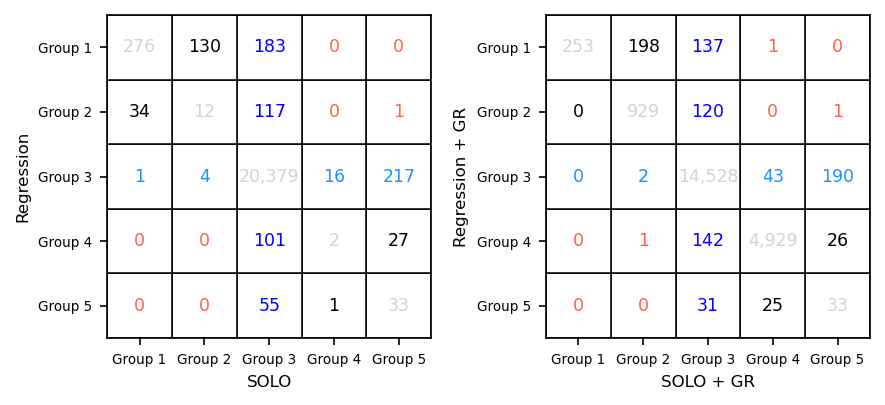

In [28]:
regression_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

regression_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

regression_GR_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION + GRADING RULES', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

custom_coloring_heatmap([regression_vs_SOLO, regression_GR_vs_SOLO_GR], saveName="../results/Figures/comparison_heatmaps.svg")

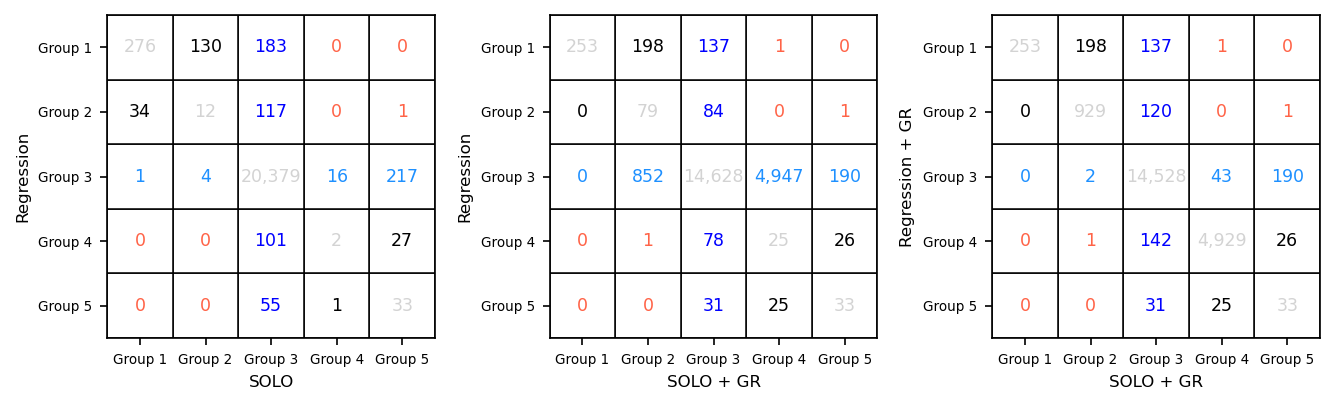

In [4]:
regression_vs_SOLO = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO INITIAL CONFIDENCE GRADING', silent=True)

regression_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION FINAL CONFIDENCE GRADING', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

regression_GR_vs_SOLO_GR = make_solo_regression_comparison_table(results_final, regression_col='REGRESSION + GRADING RULES', solo_col='SOLO FINAL CONFIDENCE GRADING', silent=True)

custom_coloring_heatmap([regression_vs_SOLO, regression_vs_SOLO_GR, regression_GR_vs_SOLO_GR])

In [11]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')) & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))]#[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_neutral_pval', 'WHO_BH_LRT_neutral_pval', 'WHO_R_PPV', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_neutral_pval']]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES


In [12]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING'].str.contains('Assoc w R'))]#[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_neutral_pval', 'WHO_BH_LRT_neutral_pval', 'WHO_R_PPV', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_neutral_pval']]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
10283,Ethionamide,ethA,ethA_p.Pro209fs,frameshift,0.914261,0.007,0.022338,0.993,1.0,0.196018,...,0.000749,0.997538,0.998901,Uncertain,4) Not assoc w R - Interim,Downgrade to Interim,3) Uncertain significance,2) Assoc w R - Interim,4) Not assoc w R - Interim,4) Not assoc w R - Interim


In [13]:
results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R'))]#[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_neutral_pval', 'WHO_BH_LRT_neutral_pval', 'WHO_R_PPV', 'WHO_Present_R', 'WHO_Present_S', 'Initial confidence grading WHO dataset', 

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
1915,Capreomycin,rrs,rrs_n.514A>C,non_coding_transcript_exon_variant,1.126057,0.0,0.0,0.998,1.0,0.000392,...,0.091402,0.974525,0.979388,Assoc w R,2) Assoc w R - Interim,Upgrade to Interim,5) Not assoc w R,5) Not assoc w R,2) Assoc w R - Interim,2) Assoc w R - Interim
10334,Isoniazid,katG,katG_c.12A>G,synonymous_variant,1.102630,0.0,0.0,1.000,1.0,0.000130,...,0.001079,0.999866,1.000000,Assoc w R,1) Assoc w R,Both Assoc w R,3) Uncertain significance,4) Not assoc w R - Interim,1) Assoc w R,1) Assoc w R


In [13]:
minor_downgrades = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['SOLO INITIAL CONFIDENCE GRADING'].str.contains('Assoc w R'))][['mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_Present_SR', 'WHO_Present_R', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_Present_SR', 'ALL_Present_R']]

minor_downgrades

,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_Present_SR,WHO_Present_R,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_Present_SR,ALL_Present_R
1091,Rv0678_p.Met146Thr,1.189196,0.000000,0.002111,11.0,11.0,1.138831,0.000000,2.408815e-23,48.0,11.0
17270,pncA_p.Ala161fs,1.048681,0.000000,0.003596,1.0,1.0,1.046482,0.000000,5.270121e-03,1.0,1.0
17333,pncA_p.Arg154fs,1.039255,0.000000,0.012894,1.0,1.0,1.037944,0.000000,1.820006e-02,1.0,1.0
17421,pncA_p.Val155Ala,1.027533,0.035816,0.031423,4.0,2.0,1.027295,0.051337,3.220765e-02,4.0,2.0
17430,pncA_p.Thr22fs,1.053269,0.000000,0.001714,2.0,2.0,1.022268,0.138163,1.885630e-01,6.0,2.0


In [12]:
who_variants.query("variant=='pncA_p.Val155Ala'")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
17954,Pyrazinamide,pncA,p.Val155Ala,pncA_p.Val155Ala,1,missense_variant,"(see ""Genomic_coordinates"" sheet)",1.0,4.0,2.0,...,NaN,2) Assoc w R - Interim,NaN,UP from Uncertain to AwRI,NaN,NaN,yes,NaN,NaN,4


In [85]:
results_final.query("mutation in ['inhA_c.-777C>T', 'katG_p.Ser315Thr', 'katG_p.Arg463Leu'] & Drug=='Isoniazid'")

,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,WHO_BH_LRT_pval,WHO_LRT_neutral_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,Drug,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION + GRADING RULES
10306,katG_p.Ser315Thr,missense_variant,17.276452,0.0,0.0,1.0,1.0,0.000000e+00,0.000000,1.000000,...,0.791116,0.989800,0.992067,Assoc w R,1) Assoc w R,Both Assoc w R,Isoniazid,1) Assoc w R,1) Assoc w R,1) Assoc w R
10307,inhA_c.-777C>T,upstream_gene_variant,3.700668,0.0,0.0,1.0,1.0,0.000000e+00,0.000000,1.000000,...,0.220478,0.992036,0.994029,Assoc w R,1) Assoc w R,Both Assoc w R,Isoniazid,1) Assoc w R,1) Assoc w R,1) Assoc w R
12361,katG_p.Arg463Leu,missense_variant,0.809764,0.0,0.0,1.0,1.0,6.890836e-07,0.000038,0.999999,...,0.584362,0.525137,0.536943,Not assoc w R,5) Not assoc w R,Both Not assoc w R,Isoniazid,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R


In [80]:
minor_downgrades[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'WHO_BH_LRT_pval', 'WHO_Present_R', 'WHO_Present_S', 'WHO_R_PPV_LB', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'ALL_Present_R', 'ALL_Present_S', 'ALL_R_PPV_LB', 'Initial confidence grading ALL dataset']]

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,WHO_BH_LRT_pval,WHO_Present_R,WHO_Present_S,WHO_R_PPV_LB,Initial confidence grading WHO dataset,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,ALL_Present_R,ALL_Present_S,ALL_R_PPV_LB,Initial confidence grading ALL dataset
1091,Bedaquiline,Rv0678_p.Met146Thr,1.188933,0.0,0.002157,11.0,0.0,0.715086,Assoc w R,1.138697,0.000000,2.574595e-23,11.0,37.0,0.120330,Uncertain
17275,Pyrazinamide,pncA_p.Ala161fs,1.048091,0.0,0.003875,1.0,0.0,0.025000,Uncertain,1.046010,0.000000,5.869496e-03,1.0,0.0,0.025000,Uncertain
17332,Pyrazinamide,pncA_p.Arg154fs,1.039218,0.0,0.013120,1.0,0.0,0.025000,Uncertain,1.037911,0.000000,1.815475e-02,1.0,0.0,0.025000,Uncertain
17430,Pyrazinamide,pncA_p.Thr22fs,1.053157,0.0,0.001821,2.0,0.0,0.158114,Assoc w R,1.022121,0.092698,1.949828e-01,2.0,4.0,0.043272,Uncertain


In [51]:
# list(who_variants.columns)

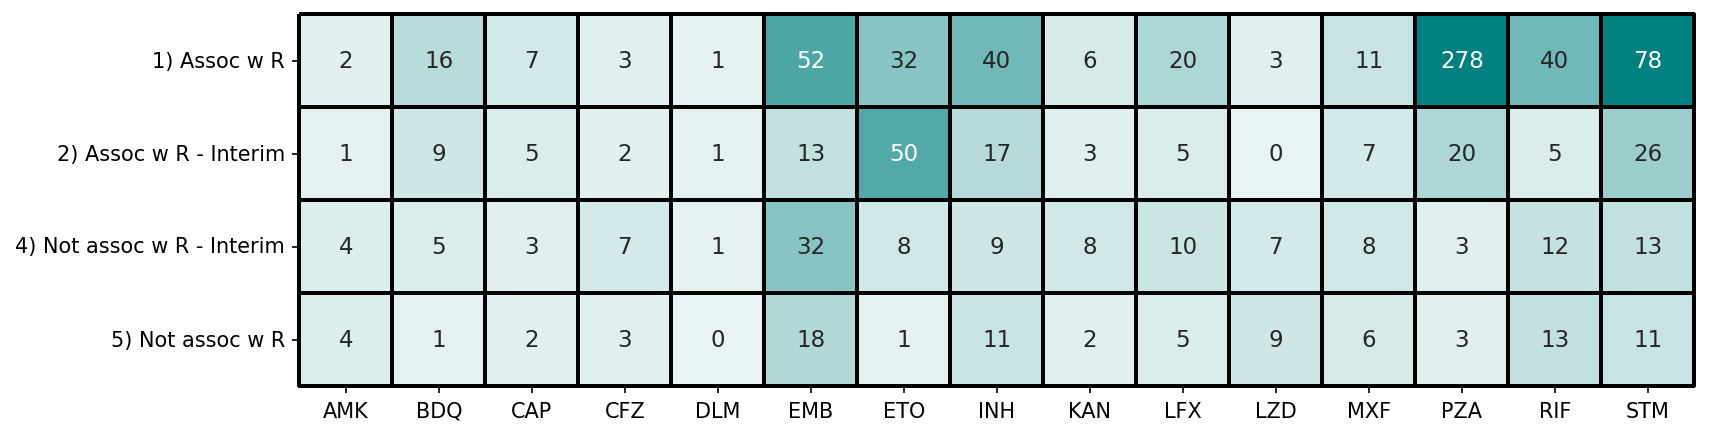

In [29]:
regression_drug_summary = pd.DataFrame(results_final.groupby("Drug")['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()).reset_index().rename(columns={"REGRESSION FINAL CONFIDENCE GRADING": "confidence"})

regression_drug_summary = regression_drug_summary.pivot(index='confidence', columns='Drug', values='count').fillna(0).astype(int)

# don't plot Uncertain mutations so that it doesn't take away attention from the other 4 groups, which is what we want people to look at
regression_drug_summary = regression_drug_summary.loc[['1) Assoc w R', '2) Assoc w R - Interim', '4) Not assoc w R - Interim', '5) Not assoc w R']]
# regression_drug_summary = regression_drug_summary.loc[['1) Assoc w R', '2) Assoc w R - Interim', '3) Uncertain significance', '4) Not assoc w R - Interim', '5) Not assoc w R']]

fig, ax = plt.subplots(figsize=(12, 4))

sns.heatmap(regression_drug_summary, 
            fmt="g",
            cmap=sns.light_palette("teal", as_cmap=True),
            vmin=0,
            vmax=np.sort(regression_drug_summary.values.flatten())[-2], # use the second highest as the top
            cbar=False,
            square=True,
            annot=True,
            annot_kws={"size": 11},
            linewidths=1, 
            linecolor='black',
            ax=ax,
            clip_on=False
           )

ax.set_xticks(ticks=ax.get_xticks(), labels=[drug_abbr_dict[drug] for drug in regression_drug_summary.columns], rotation=0)
ax.set_yticks(ticks=ax.get_yticks(), labels=ax.get_yticklabels(), rotation=0)

ax.set_xlabel('')
ax.set_ylabel('')
# plt.show()
plt.savefig("../results/Figures/summary_heatmap_by_drug.svg", format='svg', bbox_inches='tight')

# 5. INH Compensatory and Neutral Controls

In [112]:
# include all sites from -47 to -92 upstream of ahpC
ahpC_upstream_pos_region = np.arange(-92, -46).astype(str)

ahpC_exp_evidence_R = ['-81C>T', '-39C>T', '-54C>T', '-12C>T', '-51G>A', '-9G>A', '-48G>A', '-6G>A', '-52C>T', '-10C>T', '-72C>T', '-30C>T']
ahpC_exp_evidence_R = [f"ahpC_c.{var}" for var in ahpC_exp_evidence_R]

ahpC_exp_evidence_notR = ['-84T>C', '-42T>C', '-88G>A', '-46G>A', '-10G>A', '33G>A']
ahpC_exp_evidence_notR = [f"ahpC_c.{var}" for var in ahpC_exp_evidence_notR]

print(len(ahpC_exp_evidence_R), len(ahpC_exp_evidence_notR), len(ahpC_upstream_pos_region))

12 6 46


In [123]:
ahpC_save = results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')").loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')][['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'Initial confidence grading WHO dataset', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'Initial confidence grading ALL dataset', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

ahpC_save.loc[ahpC_save['mutation'].str.contains('|'.join(ahpC_upstream_pos_region)), 'Reference'] = 'Xpert'
ahpC_save.loc[ahpC_save['mutation'].isin(ahpC_exp_evidence_R), 'Reference'] = 'Experimental'

ahpC_save = ahpC_save.merge(MIC_results, on=['Drug', 'mutation'], how='left').sort_values(['REGRESSION FINAL CONFIDENCE GRADING', 'ALL_Odds_Ratio'], ascending=[True, False])

# ahpC_save.to_csv("../tables/ahpC_compens.csv", index=False)

In [125]:
ahpC_save

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,Initial confidence grading WHO dataset,ALL_Odds_Ratio,ALL_BH_pval,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,Reference,MIC_coef,MIC_BH_pval
0,Isoniazid,ahpC_c.-57C>T,1.164791,0.000000,Assoc w R,1.165730,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Xpert,0.045543,0.452746
1,Isoniazid,ahpC_c.-48G>A,1.167729,0.000000,Assoc w R,1.161256,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Experimental,0.018720,0.531243
2,Isoniazid,ahpC_c.-52C>T,1.138868,0.000000,Assoc w R,1.136985,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Experimental,0.038575,0.531243
3,Isoniazid,ahpC_c.-54C>T,1.125294,0.000000,Assoc w R,1.133066,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Experimental,0.032119,0.531243
4,Isoniazid,ahpC_c.-76T>A,1.137971,0.000000,Assoc w R,1.097433,0.0,Assoc w R,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,Xpert,0.056721,0.469385
5,Isoniazid,ahpC_c.-72C>T,1.045262,0.014095,Uncertain,1.081046,0.0,Assoc w R,2) Assoc w R - Interim,3) Uncertain significance,3) Uncertain significance,Experimental,0.114191,0.020432


In [128]:
results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')")['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()

REGRESSION FINAL CONFIDENCE GRADING
3) Uncertain significance    62
1) Assoc w R                  5
2) Assoc w R - Interim        1
Name: count, dtype: int64

In [127]:
results_final.query("mutation.str.contains('ahpC') & mutation.str.contains('_c.-')").loc[results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc')][['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_neutral_pval']]

,mutation,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_neutral_pval


In [131]:
# all Uncertain by regression
results_final.query("mutation in @ahpC_exp_evidence_notR")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
12124,Isoniazid,ahpC,ahpC_c.-84T>C,upstream_gene_variant,0.984990,0.358,0.5569,0.486,0.826498,0.717763,...,0.000179,0.999738,0.999991,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
12151,Isoniazid,ahpC,ahpC_c.-10G>A,upstream_gene_variant,0.984112,0.359,0.5569,0.481,0.824756,0.702467,...,0.000179,0.999738,0.999991,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
12264,Isoniazid,ahpC,ahpC_c.-88G>A,upstream_gene_variant,0.948416,0.056,0.1980,0.878,1.000000,1.000000,...,0.074576,0.853212,0.861495,Uncertain,3) Uncertain significance,Both Uncertain,5) Not assoc w R,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance


# 6. Direct Association-Based Prediction Comparison between SOLO and Regression

<ul>
    <li>SOLO vs. Regression-identified mutations</li>
    <li>Catalog method vs. Regression model</li>
    <li>+/- HETs</li>
</ul>


In [18]:
for drug in os.listdir(analysis_dir):
    
    if not os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/model_stats_AF75_SOLO__R_abrogating_muts.csv")) and os.path.isfile(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/model_stats_AF75_SOLO_.csv")):
        shutil.copy(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/model_stats_AF75_SOLO_.csv"), os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/model_stats_AF75_SOLO__R_abrogating_muts.csv"))

In [33]:
def single_metric_solo_regression_comparison(drugs_lst, metric="Sens", remove_discrepancies=False, include_regression_GR=True, saveName=None):

    fig, axs = plt.subplots(3, 5, figsize=(11, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)

    plot_df = []
    phenos_name = "ALL"
    
    for drug in drugs_lst:

        reg_model_suffix = ''
    
        if remove_discrepancies and drug in ['Capreomycin', 'Isoniazid']:
            reg_model_suffix += '_remove_discrepancies' # only for regression, not SOLO
    
        if drug != "Pretomanid":
            stats_solo_initial = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_SOLO.csv"))
            stats_solo_initial['Drug'] = drug
            stats_solo_initial['Model'] = 'SOLO'
            
            stats_solo_final = solo_binary_stats.query("Drug==@drug").reset_index()
            stats_solo_final['Model'] = 'SOLO + GR'
            
            stats_regression = pd.read_csv(os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75{reg_model_suffix}.csv"))
            stats_regression['Drug'] = drug
                
            plot_df.append(stats_solo_initial)
            plot_df.append(stats_solo_final)
            plot_df.append(stats_regression)
            
            if include_regression_GR:
                
                results_fName_GR = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos={phenos_name}/model_stats_AF75_GR{reg_model_suffix}.csv")
                stats_regression_GR = pd.read_csv(results_fName_GR)
                stats_regression_GR['Drug'] = drug
                stats_regression_GR['Model'] = 'Regression + GR'

                plot_df.append(stats_regression_GR)

    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')
    
    # Categories and metric names
    if include_regression_GR:
        categories = ['SOLO', 'SOLO + GR', 'Regression', 'Regression + GR']
    else:
        categories = ['SOLO', 'SOLO + GR', 'Regression']

    # SOLO green, Regression orange
    colors = {'SOLO': sns.color_palette("Set3").as_hex()[0],#sns.color_palette("Set2")[0], 
              'Regression': sns.color_palette("Set3").as_hex()[5], #sns.color_palette("Set2")[1], 
              'Regression + GR': sns.color_palette("Set3").as_hex()[8],
              'SOLO + GR': sns.color_palette("Set3").as_hex()[2], #sns.color_palette("Set2")[2]
             }
    
    # colors = dict(zip(categories, np.concatenate([sns.color_palette("Paired")[:2], sns.color_palette("Paired")[6:8]])))
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]
        # metric_pval = compute_ci_ztest(single_drug_plot_df, metric, var1, var2, single_drug_plot_df.index.values[0], single_drug_plot_df.index.values[1])
        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')#, alpha=0.75)
            ax.bar_label(patch, label_type='center', fmt='%.1f', fontsize=9)
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
        
        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    # plt.legend(bbox_to_anchor=(0.08, -0.17), loc="lower right", ncol=len(categories))
    plt.legend(bbox_to_anchor=(-1.6, -0.17), loc="lower center", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        if remove_discrepancies:
            saveName = saveName.replace('.png', '') + "_remove_discrepancies.png"
            
        plt.savefig(saveName, format='svg', bbox_inches="tight")

    plt.close()
    return plot_df

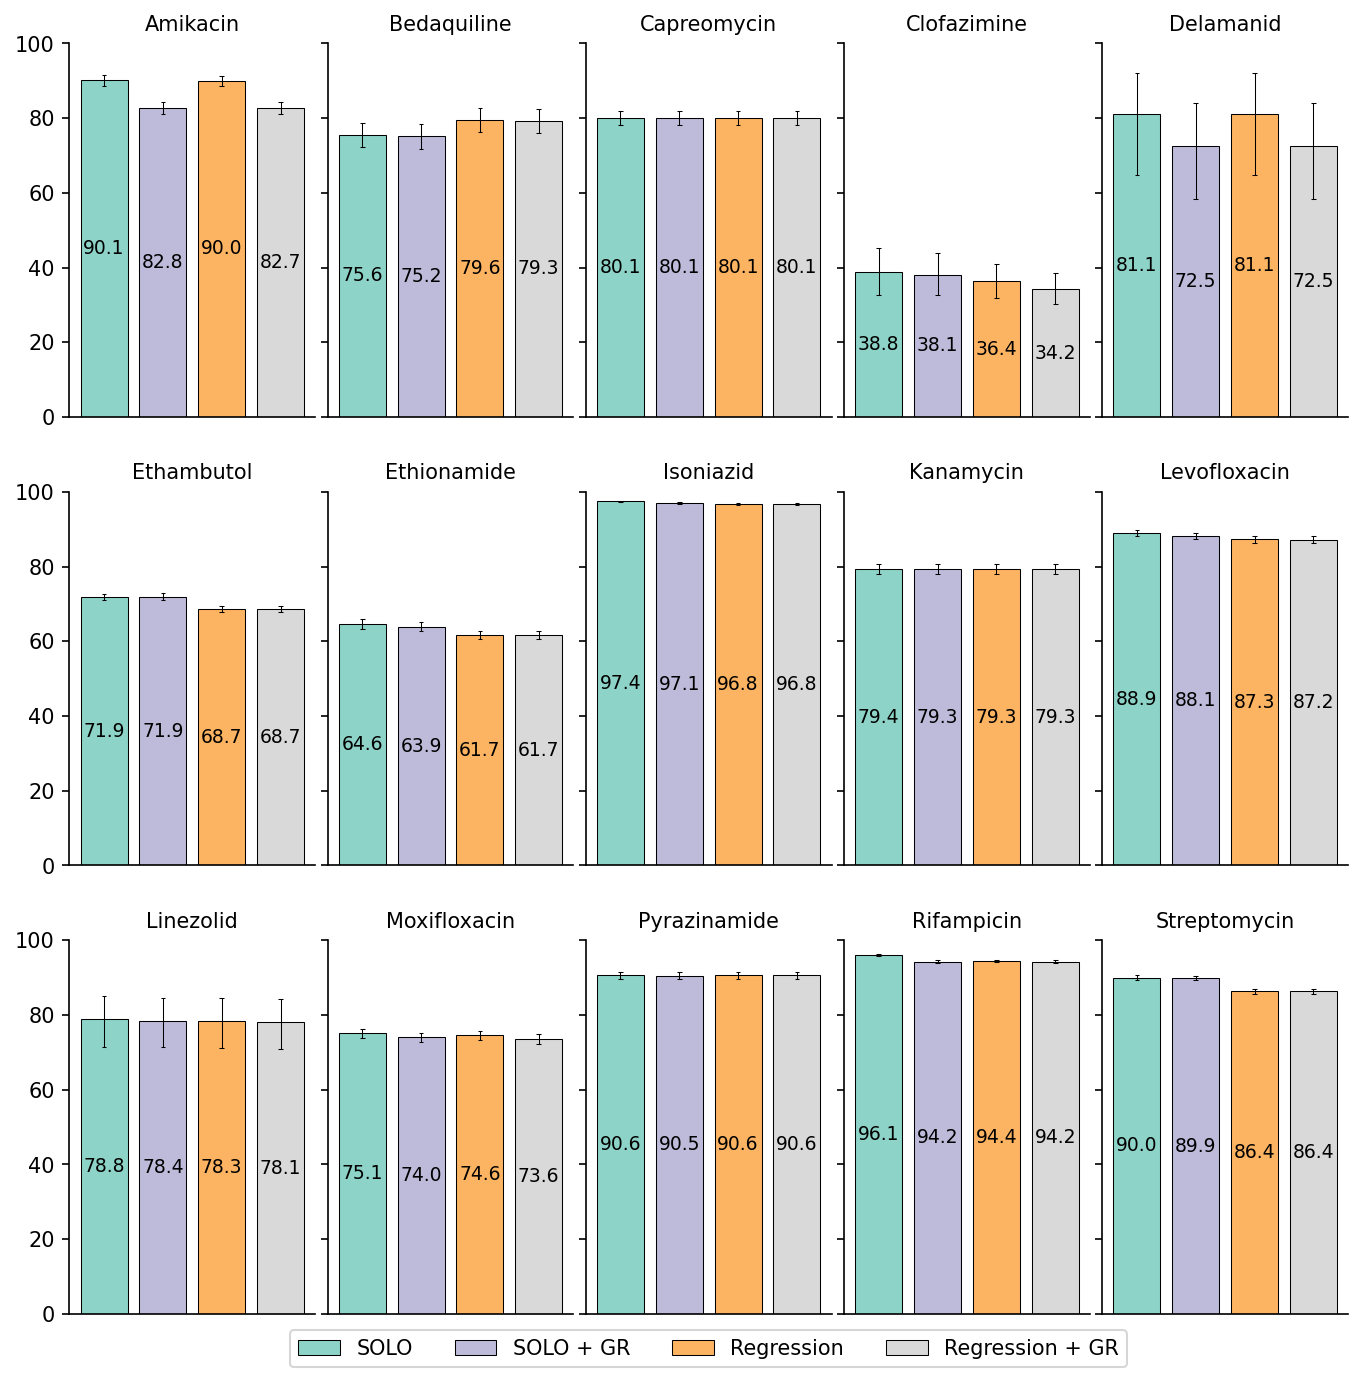

In [34]:
binary_metrics_df = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", remove_discrepancies=False, saveName="../results/Figures/PPV_comparison_fixed.svg")
binary_metrics_df_remove_discrepancies = single_metric_solo_regression_comparison(drugs_lst, metric="PPV", remove_discrepancies=True)

# save
binary_metrics_df.sort_values(["Drug", "Model"]).to_csv("../tables/binary_metrics_fixed.csv")
binary_metrics_df_remove_discrepancies.sort_values(["Drug", "Model"]).to_csv("../tables/binary_metrics_remove_discrepancies_fixed.csv")

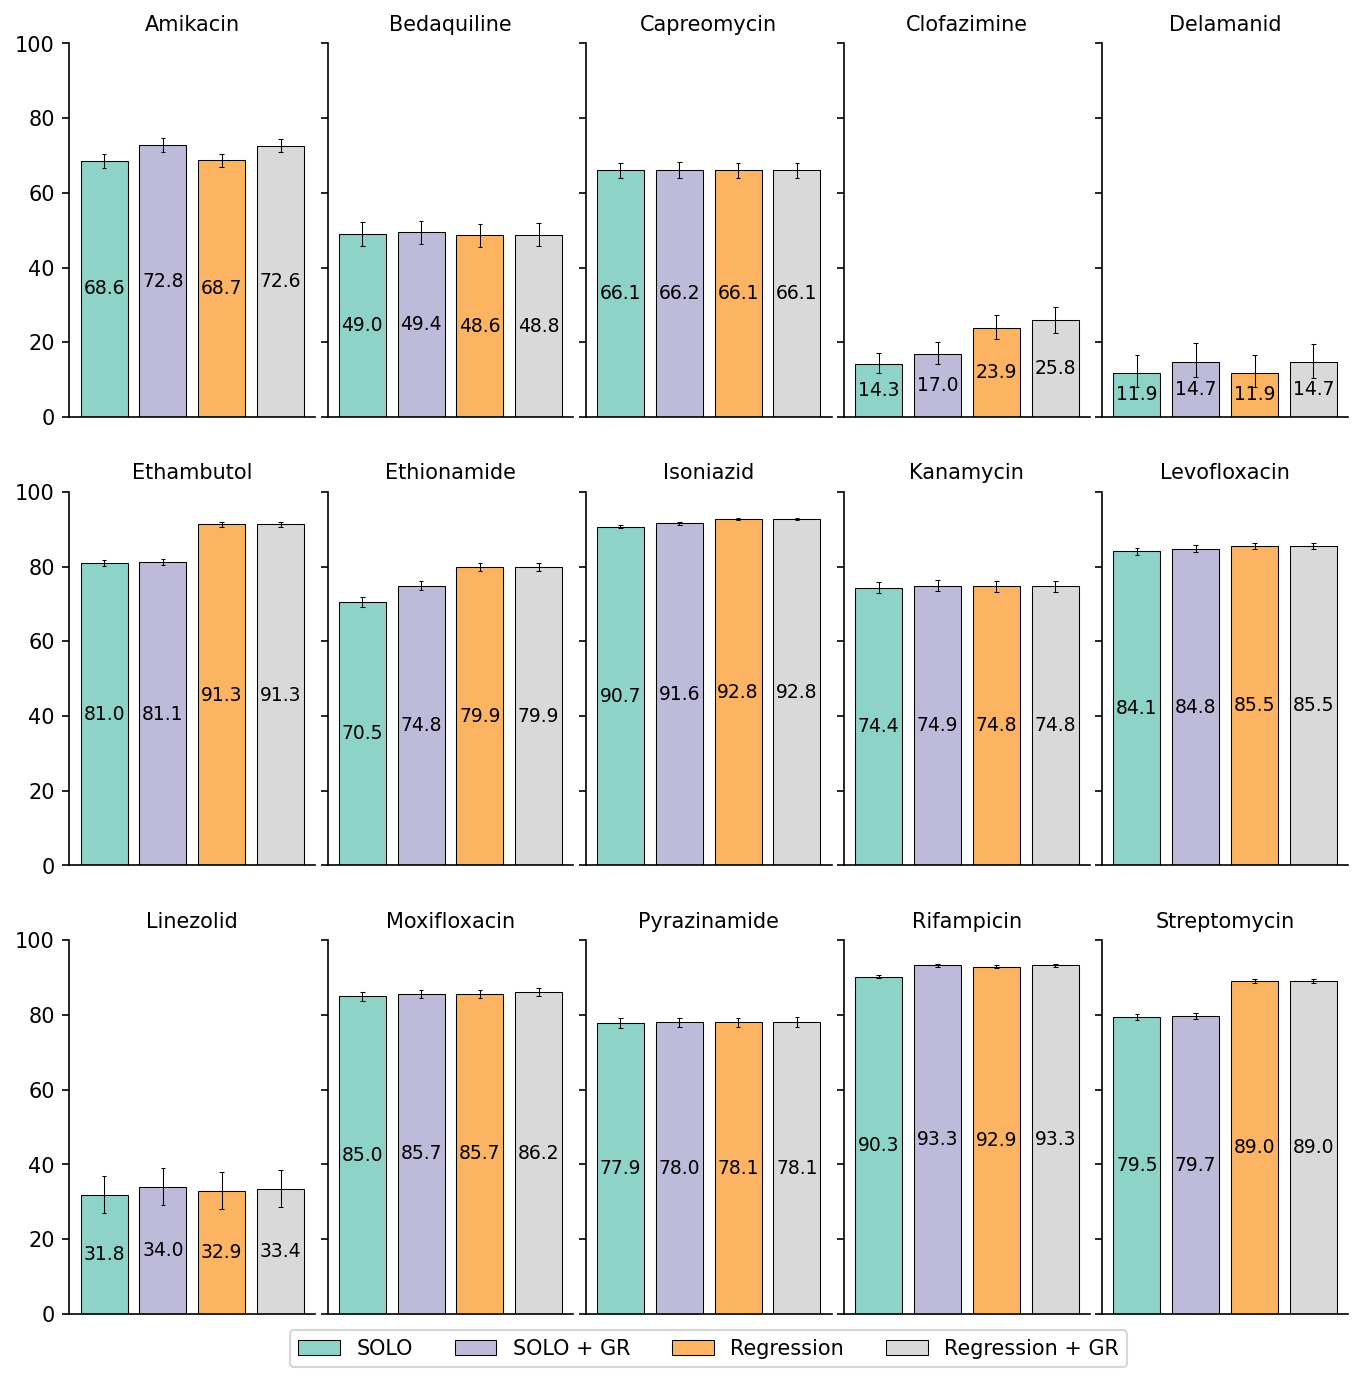

In [35]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Sens", remove_discrepancies=True)
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Sens", remove_discrepancies=False, saveName="../results/Figures/Sens_comparison_fixed.svg")

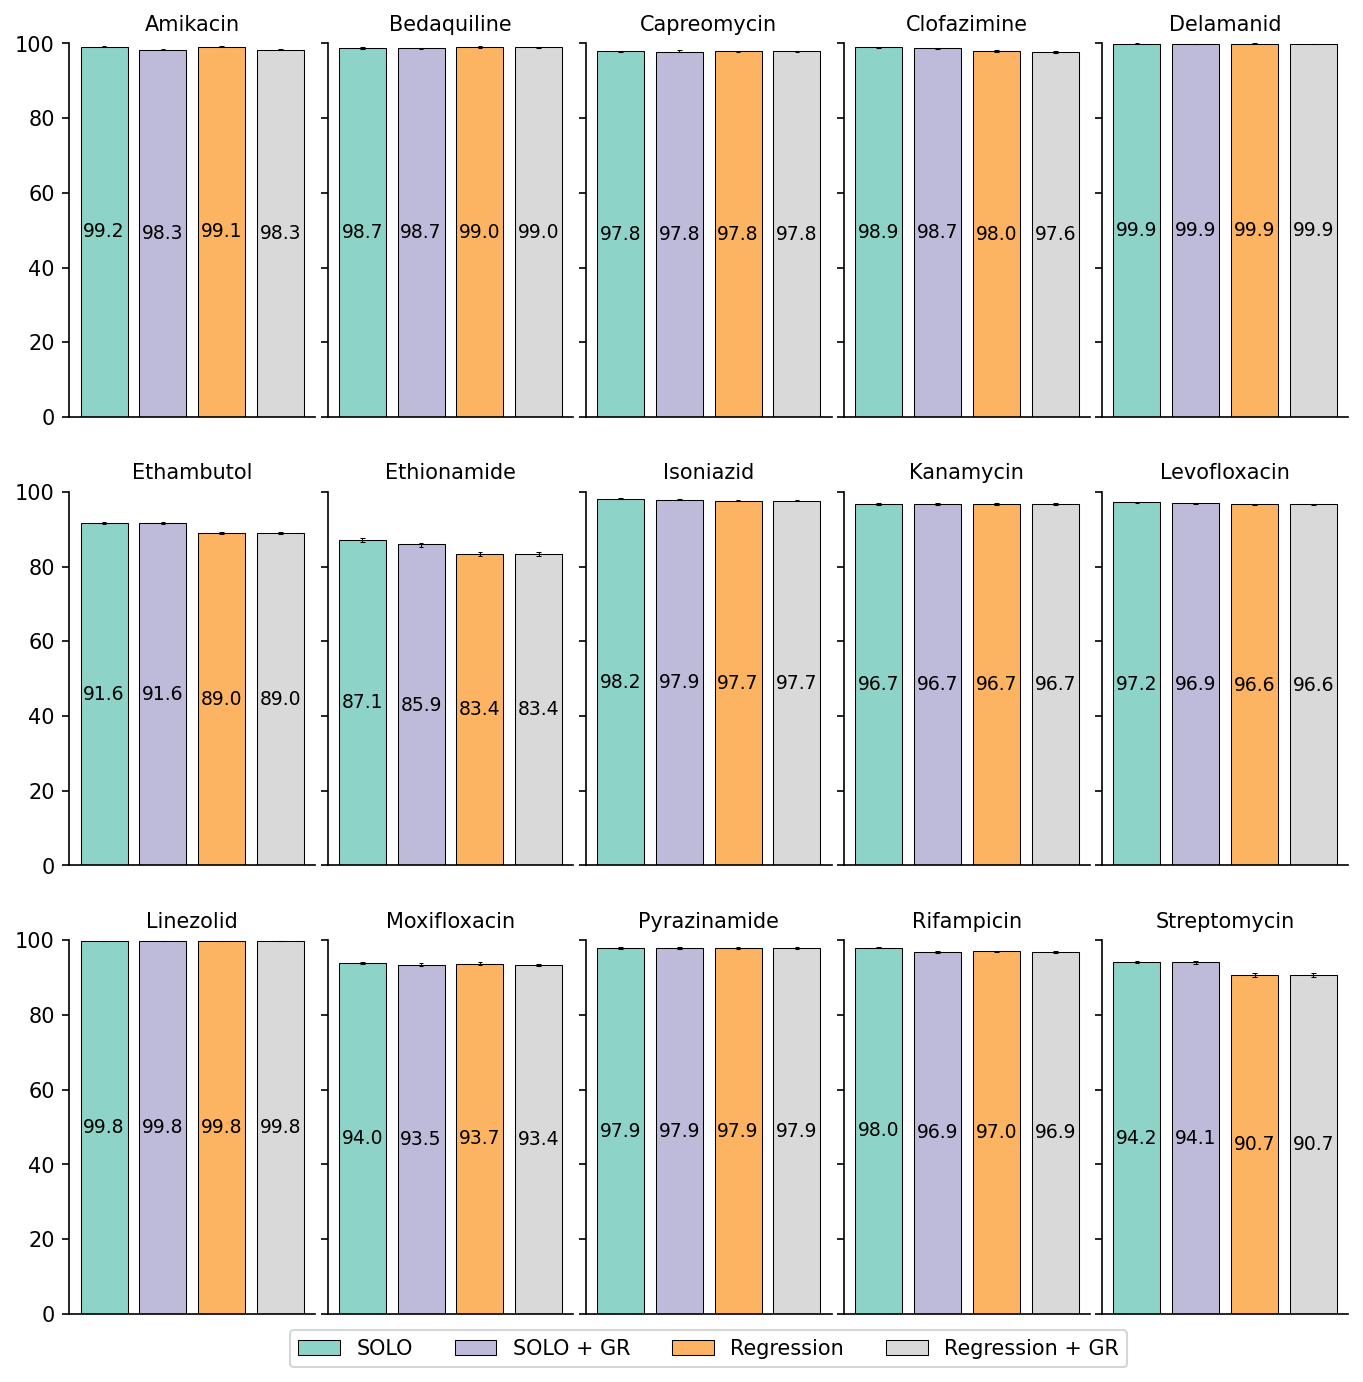

In [36]:
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", remove_discrepancies=True)
_ = single_metric_solo_regression_comparison(drugs_lst, metric="Spec", remove_discrepancies=False, saveName="../results/Figures/Spec_comparison_fixed.svg")

In [37]:
# F1 scores: PPV * sens / (PPV + sens)
print(f"SOLO F1: {binary_metrics_df.loc['SOLO']['F1'].mean()*100}")
print(f"SOLO + GR F1: {binary_metrics_df.loc['SOLO + GR']['F1'].mean()*100}")
print(f"Regression F1: {binary_metrics_df.loc['Regression']['F1'].mean()*100}")
print(f"Regression F1 remove discrepancies: {binary_metrics_df_remove_discrepancies.loc['Regression']['F1'].mean()*100}")

SOLO F1: 69.24224388943
SOLO + GR F1: 69.94689238258516
Regression F1: 70.1847895998264
Regression F1 remove discrepancies: 70.51201652697301


In [38]:
diff_df_SOLO_initial = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_SOLO_initial.index.values:
    for metric in diff_df_SOLO_initial.columns:
        diff_df_SOLO_initial.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO", metric]

diff_df_SOLO_initial['combined_diff'] = (np.abs(diff_df_SOLO_initial['Sens']) + np.abs(diff_df_SOLO_initial['Spec'])) / 2

In [39]:
# diff_df_SOLO_final = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

# for drug in diff_df_SOLO_final.index.values:
#     for metric in diff_df_SOLO_final.columns:
#         diff_df_SOLO_final.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression", metric] - binary_metrics_df.query("Drug==@drug").loc["SOLO + GR", metric]

In [56]:
diff_df_regression_GR = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_regression_GR.index.values:
    for metric in diff_df_regression_GR.columns:
        diff_df_regression_GR.loc[drug, metric] = binary_metrics_df.query("Drug==@drug").loc["Regression + GR", metric] - binary_metrics_df.query("Drug==@drug").loc["Regression", metric]

In [57]:
diff_df_regression_GR.query("Sens > 0").sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Amikacin,0.039113,-0.008457,-0.073253,0.003875,-0.006034
Delamanid,0.027778,-0.000606,-0.085321,0.000573,0.036612
Clofazimine,0.019202,-0.003725,-0.021579,0.00074,0.005843
Linezolid,0.005348,-0.000057,-0.002189,0.00011,0.004888
Moxifloxacin,0.004963,-0.003519,-0.009355,0.000955,-0.003266
Rifampicin,0.004389,-0.001263,-0.00196,0.002243,0.001257
Bedaquiline,0.001929,-0.000229,-0.003105,0.000134,0.000586
Pyrazinamide,0.000226,-0.000118,-0.00045,0.000048,-0.000063


In [71]:
search_variants = results_final.query("Drug=='Delamanid'").loc[(results_final['REGRESSION GRADING + LOF UPGRADE'] != results_final['REGRESSION + GRADING RULES']) & (results_final['REGRESSION + GRADING RULES'].str.contains('Assoc w R'))].mutation.values

search_variants

array(['fgd1_LoF', 'fbiC_LoF', 'fgd1_p.Asn112fs', 'fbiA_p.Val329fs',
       'fbiA_LoF', 'fbiC_p.Pro362fs', 'fgd1_deletion', 'fbiC_p.Ser443fs',
       'fbiB_p.Val17fs', 'fbiB_LoF', 'fbiC_p.Ala639fs', 'fbiC_p.Ala856fs',
       'fbiC_p.Ala855fs', 'fbiC_p.Ala487fs', 'Rv2983_LoF',
       'Rv2983_p.Thr191fs'], dtype=object)

In [42]:
def print_summaries_of_metric_comparisons(df, metric):

    reg_better = df.query(f"{metric} > 0")
    solo_better = df.query(f"{metric} < 0")
    reg_solo_same = df.query(f"{metric} == 0")

    print(f"Regression better for {len(reg_better)}")
    print(f"SOLO better for {len(solo_better)}")
    print(f"Models same for {len(reg_solo_same)}")

    if len(reg_better) > len(solo_better):
        print(f"Difference range: {reg_better[metric].min()*100}-{reg_better[metric].max()*100}")
    else:
        print(f"Difference range: {solo_better[metric].min()*100}-{solo_better[metric].max()*100}")

In [43]:
print_summaries_of_metric_comparisons(diff_df_SOLO_initial, 'Sens')

Regression better for 13
SOLO better for 1
Models same for 1
Difference range: 0.08064516129032695-10.23489932885906


In [44]:
print_summaries_of_metric_comparisons(diff_df_SOLO_initial, 'Spec')

Regression better for 2
SOLO better for 12
Models same for 1
Difference range: -3.70181586492514--0.011340440009088848


In [45]:
print_summaries_of_metric_comparisons(diff_df_SOLO_initial, 'PPV')

Regression better for 2
SOLO better for 12
Models same for 1
Difference range: -12.733960841365366--0.10318000784167447


In [53]:
diff_df_SOLO_initial.Sens.mean()*100, diff_df_SOLO_initial.Spec.mean()*100, diff_df_SOLO_initial.PPV.mean()*100

(3.2361860607974067, -0.9968224327825218, -1.742308512042953)

In [81]:
who_variants.query("drug=='Amikacin'").loc[who_variants['FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].sort_values("variant")

,drug,gene,mutation,variant,tier,effect,ALL_genomic position,ALL_algorithm_pass,ALL_Present_SOLO_SR,ALL_Present_SOLO_R,...,Additional grading criteria applied,FINAL CONFIDENCE GRADING,Comment,CHANGES vs ver1,"Relaxed thresholds simulation (BDQ_Rv0678, CFZ_Rv0678, INH_katG, DLM_ddn/fbiA/fbiB/fbiC/fgd1/Rv2983)",Silent mutation,Listed in abridged tables,Additional grading,Footnote,CHANGES vs ver1.1
17,Amikacin,eis,c.-14C>T,eis_c.-14C>T,1,upstream_gene_variant,2715346,1.0,200.0,72.0,...,WHO-endorsed gDST assay,2) Assoc w R - Interim,Can only confer resistance if genetically link...,DOWN from AwR to AwRI,NaN,NaN,yes,WHO-end. gDST,A,3
475,Amikacin,rrs,n.1401A>G,rrs_n.1401A>G,1,non_coding_transcript_exon_variant,1473246,1.0,1648.0,1526.0,...,NaN,1) Assoc w R,NaN,No change,NaN,NaN,yes,NaN,NaN,1
477,Amikacin,rrs,n.1402C>T,rrs_n.1402C>T,1,non_coding_transcript_exon_variant,1473247,1.0,18.0,6.0,...,WHO-endorsed gDST assay,2) Assoc w R - Interim,NaN,No change,NaN,NaN,yes,WHO-end. gDST,NaN,1
527,Amikacin,rrs,n.1484G>T,rrs_n.1484G>T,1,non_coding_transcript_exon_variant,1473329,1.0,17.0,12.0,...,NaN,1) Assoc w R,NaN,UP from AwRI to AwR,NaN,NaN,yes,NaN,NaN,4


In [82]:
results_final.query("Drug=='Amikacin'").loc[results_final['REGRESSION + GRADING RULES'].str.contains('Assoc w R')].sort_values("mutation")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
1,Amikacin,eis,eis_c.-14C>T,upstream_gene_variant,1.392469,0.000,0.000000,1.000,1.000000,1.477512e-39,...,0.045699,0.988936,0.991616,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,2) Assoc w R - Interim,3) Uncertain significance,2) Assoc w R - Interim
2,Amikacin,eis,eis_p.Trp36Arg,missense_variant,1.034915,0.088,0.414118,0.404,0.577143,2.682682e-01,...,0.006159,0.999587,0.999971,Assoc w R,2) Assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,2) Assoc w R - Interim,2) Assoc w R - Interim
0,Amikacin,rrs,rrs_n.1401A>G,non_coding_transcript_exon_variant,4.599413,0.000,0.000000,1.000,1.000000,0.000000e+00,...,0.732114,0.990498,0.992973,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R
4,Amikacin,rrs,rrs_n.1402C>T,non_coding_transcript_exon_variant,1.124324,0.000,0.000000,0.983,1.000000,3.697509e-09,...,0.007295,0.998835,0.999605,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,2) Assoc w R - Interim,3) Uncertain significance,2) Assoc w R - Interim
3,Amikacin,rrs,rrs_n.1484G>T,non_coding_transcript_exon_variant,1.185034,0.000,0.000000,1.000,1.000000,3.182822e-25,...,0.010560,0.999013,0.999708,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R


In [48]:
def single_metric_HET_comparison(drugs_lst, metric="Sens", model_1='model_stats_AF75', model_2='model_stats_AF25', remove_discrepancies=False, title=None, saveName=None):

    # model_stats_AF75_withLoF_gradingRules
    
    plot_df = []
    
    if '25' in model_2:
        group_1 = 'AF = 75%'
        group_2 = 'AF = 25%'
    else:
        group_1 = 'Regression'
        group_2 = 'Regression + GR'
        
    
    for drug in drugs_lst:
    
        if drug != "Pretomanid":

            if remove_discrepancies and drug in ['Capreomycin', 'Isoniazid']:
                fName_1 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_1}_remove_discrepancies.csv")
                fName_2 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_2}_remove_discrepancies.csv")
                
            else:
                fName_1 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_1}.csv")
                fName_2 = os.path.join(analysis_dir, drug, f"BINARY/tiers=1/phenos=ALL/{model_2}.csv")
                
            stats_1 = pd.read_csv(fName_1)
            stats_2 = pd.read_csv(fName_2)

            stats_1['Model'] = [group_1]
            stats_1['Drug'] = drug
            
            stats_2['Model'] = [group_2]
            stats_2['Drug'] = drug

            plot_df.append(stats_1)
            plot_df.append(stats_2)
        
    # drop columns (metrics) that have NaNs because they're not in the SOLO dataframe
    plot_df = pd.concat(plot_df, axis=0).dropna(axis=1).set_index('Model')

    fig, axs = plt.subplots(3, 5, figsize=(8, 11), sharex=True, sharey=True)
    axs = axs.flatten()
    plt.subplots_adjust(wspace=0.05)
    
    # Categories and metric names
    categories = plot_df.index.unique()

    # keep orange color (index 1) for regression, then select the next color for +HETs
    colors = {group_1: sns.color_palette("Set3").as_hex()[5], 'AF = 25%': sns.color_palette("Set3").as_hex()[4], 'Regression + GR': sns.color_palette("Set3").as_hex()[8]}
    
    # Bar width and positions
    bar_width = 0.05
    # bar_positions = np.arange(len(categories))
    
    errwidth = 0.04
    errlinewidth = 0.5
    
    for i, drug in enumerate(np.sort(plot_df['Drug'].unique())):

        single_drug_plot_df = plot_df.query("Drug==@drug")
        del single_drug_plot_df['Drug'] # remove so that the only remaining columns are numeric

        var1, var2 = metrics_components_dict[metric]        
        ax = axs[i]
        
        # Plot bars for each category
        for j, category in enumerate(categories):
    
            test = single_drug_plot_df.loc[category][metric] * 100
            lower = single_drug_plot_df.loc[category][f"{metric}_lb"] * 100
            upper = single_drug_plot_df.loc[category][f"{metric}_ub"] * 100
            
            # Plot the test value as a bar
            patch = ax.bar(j, test, color=colors[category], label=category, linewidth=0.5, edgecolor='black')
            ax.bar_label(patch, label_type='center', fmt='%.1f')
            
            # Plot the confidence interval as a vertical line
            ax.vlines(j, lower, upper, color='black', linewidth=errlinewidth)
    
            # plot horizontal lines to make the error bars look nicer
            ax.hlines(lower, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)
            ax.hlines(upper, j - errwidth, j + errwidth, color='black', linewidth=errlinewidth)

        ax.set_title(drug, fontsize=10)
        
        # remove x-axis ticks and labels
        ax.set_xticks([])
        ax.set_xticklabels([])
    
    # Show the plot
    plt.legend(bbox_to_anchor=(-0.5, -0.17), loc="lower right", ncol=len(categories))
    sns.despine()
    plt.tight_layout()
    plt.ylim(0, 100)

    if title is not None:
        plt.suptitle(title)
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, format='svg', bbox_inches="tight")

    plt.close()
    return plot_df

In [49]:
HET_results = single_metric_HET_comparison(drugs_lst, metric="Sens", model_2='model_stats_AF25', saveName="../results/Figures/Sens_comparison_withHETs_fixed.svg")

_ = single_metric_HET_comparison(drugs_lst, metric="Spec", model_2='model_stats_AF25', saveName="../results/Figures/Spec_comparison_withHETs_fixed.svg")
_ = single_metric_HET_comparison(drugs_lst, metric="PPV", model_2='model_stats_AF25', saveName="../results/Figures/PPV_comparison_withHETs_fixed.svg")

# save
HET_results.sort_values(["Drug", "Model"]).to_csv("../tables/binary_metrics_withHETs_fixed.csv")

In [54]:
diff_df_HET = pd.DataFrame(columns=["Sens", "Spec", "PPV", "NPV", "F1"], index=[drug for drug in drugs_lst if drug != "Pretomanid"])

for drug in diff_df_HET.index.values:

    for metric in diff_df_HET.columns:
        diff_df_HET.loc[drug, metric] = HET_results.query("Drug==@drug").loc["AF = 25%", metric] - HET_results.query("Drug==@drug").loc["AF = 75%", metric]

In [72]:
diff_df_HET.sort_values("Sens", ascending=False)

,Sens,Spec,PPV,NPV,F1
Bedaquiline,0.103182,-0.002901,-0.010861,0.007582,0.069685
Moxifloxacin,0.046898,-0.003626,-0.000534,0.010104,0.019414
Levofloxacin,0.044603,-0.002673,-0.002831,0.011606,0.020719
Clofazimine,0.038405,-0.003022,0.001714,0.001636,0.026931
Capreomycin,0.031477,-0.002684,-0.003272,0.003889,0.013615
Amikacin,0.024194,-0.00099,-0.006994,0.002516,0.012591
Kanamycin,0.023536,-0.001285,-0.001161,0.003756,0.011722
Pyrazinamide,0.021214,-0.001066,-0.001915,0.005048,0.011248
Ethionamide,0.013929,-0.003568,-0.000948,0.004524,0.00462
Linezolid,0.013369,-0.000397,-0.026043,0.000271,0.008178


In [73]:
HET_results.query("Drug in ['Clofazimine', 'Bedaquiline', 'Moxifloxacin', 'Levofloxacin']").loc['AF = 25%', ['Drug', 'Sens', 'Sens_lb', 'Sens_ub']]

,Drug,Sens,Sens_lb,Sens_ub
Model,,,,
AF = 25%,Bedaquiline,0.589200,0.558556,0.619336
AF = 25%,Clofazimine,0.277696,0.244252,0.313091
AF = 25%,Moxifloxacin,0.903474,0.893938,0.912421
AF = 25%,Levofloxacin,0.899728,0.891762,0.907294


# Volcano Plots of MIC Results for Mutations 1) Assoc w R by Regression and Uncertain by SOLO

In [42]:
# variants graded in not Uncertain by regression and Uncertain by DA
# already includes filter for Num_Isolates ≥ 5 when grading.
# also exclude variant that are Neutral in the WHO dataset because we wouldn't expect them to have significant MIC coefficients
search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['3) Uncertain significance'])) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance') & (results_final['Initial confidence grading WHO dataset'] != 'Neutral') & (results_final['Initial confidence grading ALL dataset'] != 'Neutral')].reset_index(drop=True)

# search_df = results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].isin(['Uncertain', 'Neutral'])) & (~results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Interim')) & (results_final['SOLO INITIAL CONFIDENCE GRADING']=='3) Uncertain significance')]

print(f"Examining MIC results for {len(search_df)} variants")
search_df = search_df.merge(MIC_results, on=['Drug', 'mutation'], how='left')

# keep only those with MIC results
MIC_test_variants = search_df.loc[(~pd.isnull(search_df['MIC_BH_pval']))]
print(f"{len(MIC_test_variants)}/{len(search_df)} ({np.round(len(MIC_test_variants)/len(search_df)*100, 1)}%) variants have MIC results")

Examining MIC results for 372 variants
303/372 (81.5%) variants have MIC results


In [43]:
MIC_test_variants_WHO_significant = MIC_test_variants.query("(WHO_BH_pval <= 0.05 & predicted_effect not in @silent_lst) | (WHO_BH_pval <= 0.01 & predicted_effect in @silent_lst)")

len(MIC_test_variants_WHO_significant)

233

In [44]:
denom = len(MIC_test_variants_WHO_significant.loc[MIC_test_variants_WHO_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')])
numer = len(MIC_test_variants_WHO_significant.loc[MIC_test_variants_WHO_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')].query("MIC_coef > 0 & (MIC_BH_pval <= 0.05 & predicted_effect not in @silent_lst) | (MIC_BH_pval <= 0.01 & predicted_effect in @silent_lst)"))

denom, numer, numer/denom

(207, 73, 0.3526570048309179)

In [45]:
denom = len(MIC_test_variants_WHO_significant.loc[MIC_test_variants_WHO_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')])
numer = len(MIC_test_variants_WHO_significant.loc[MIC_test_variants_WHO_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')].query("MIC_coef < 0 & (MIC_BH_pval <= 0.05 & predicted_effect not in @silent_lst) | (MIC_BH_pval <= 0.01 & predicted_effect in @silent_lst)"))

denom, numer, numer/denom

(26, 6, 0.23076923076923078)

In [46]:
79/233

0.33905579399141633

In [47]:
MIC_test_variants_WHO_significant.loc[MIC_test_variants_WHO_significant['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc w R')].query("MIC_coef < 0 & (MIC_BH_pval <= 0.05 & predicted_effect not in @silent_lst) | (MIC_BH_pval <= 0.01 & predicted_effect in @silent_lst)")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval
2,Amikacin,eis,eis_c.-9T>C,upstream_gene_variant,0.935680,0.000,0.000000,1.000,1.0,0.042252,...,0.999924,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.037098,0.0
3,Amikacin,eis,eis_p.Met1?,start_lost,0.913603,0.000,0.000000,1.000,1.0,0.003814,...,0.999867,Not assoc w R,5) Not assoc w R,Both Not assoc w R,3) Uncertain significance,3) Uncertain significance,5) Not assoc w R,5) Not assoc w R,-0.032758,0.0
5,Amikacin,eis,eis_p.His150fs,frameshift,0.867499,0.000,0.000000,1.000,1.0,0.000019,...,0.999533,Not assoc w R,5) Not assoc w R,Both Not assoc w R,3) Uncertain significance,3) Uncertain significance,5) Not assoc w R,5) Not assoc w R,-0.047815,0.0
8,Bedaquiline,mmpL5,mmpL5_LoF,LoF,0.820561,0.017,0.046266,0.976,1.0,0.012029,...,0.983809,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.322691,0.0
202,Kanamycin,eis,eis_p.Met1?,start_lost,0.889921,0.000,0.000000,1.000,1.0,0.000010,...,0.999890,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.049568,0.0
204,Kanamycin,eis,eis_p.His150fs,frameshift,0.885503,0.000,0.000000,1.000,1.0,0.000024,...,0.999828,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.074196,0.0


In [75]:
def plot_MIC_results_with_OR(df, pheno_group='WHO', saveName=None):

    # negative log-p-value
    df['log_MIC_BH_pval'] = -np.log(df['MIC_BH_pval'])
    
    # for variants with a p-value of 0, replace with the next smallest p-value
    df.loc[df['MIC_BH_pval'] == 0, 'log_MIC_BH_pval'] = -np.log(np.sort(df['MIC_BH_pval'].unique())[1])
    
    df.loc[((df['MIC_coef'] > 0) & ((df['MIC_BH_pval'] <= 0.05) & (~df['predicted_effect'].isin(silent_lst))) | ((df['MIC_BH_pval'] <= 0.01) & (df['predicted_effect'].isin(silent_lst)))), 'color'] = sns.color_palette('Blues').as_hex()[-1]
    
    df.loc[((df['MIC_coef'] < 0) & ((df['MIC_BH_pval'] <= 0.05) & (~df['predicted_effect'].isin(silent_lst))) | ((df['MIC_BH_pval'] <= 0.01) & (df['predicted_effect'].isin(silent_lst)))), 'color'] = 'darkred'
    
    df.loc[((df['MIC_BH_pval'] > 0.05) & (~df['predicted_effect'].isin(silent_lst))) | ((df['MIC_BH_pval'] > 0.01) & (df['predicted_effect'].isin(silent_lst))), 'color'] = 'lightgray'

    # only plot those with significant binary associations
    df = df.query(f"({pheno_group}_BH_pval <= 0.01 & predicted_effect in @silent_lst) | ({pheno_group}_BH_pval <= 0.05 & predicted_effect not in @silent_lst)")
    
    #color_dict = dict(zip(plot_df.query("color != 'lightgray'")['REGRESSION FINAL CONFIDENCE GRADING'], plot_df.query("color != 'lightgray'")['color']))
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))    
    
    sns.scatterplot(data=df.query(f"{pheno_group}_Odds_Ratio < 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                    x='MIC_coef',
                    y=f"{pheno_group}_Odds_Ratio",
                    #y='log_MIC_BH_pval',
                    hue='color',
                    palette={color:color for color in df.color.unique()},
                    #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                    legend=True,
                    alpha=0.9,
                    linewidth=0.5,
                    s=50,
                    ax=axs[0]
                   )
    
    sns.scatterplot(data=df.query(f"{pheno_group}_Odds_Ratio > 1").sort_values('color', ascending=False), # put lightgray at the beginning so it gets plotted below
                    x='MIC_coef',
                    y=f"{pheno_group}_Odds_Ratio",
                    #y='log_MIC_BH_pval',
                    hue='color',
                    palette={color:color for color in df.color.unique()},
                    #palette={'Assoc w R': sns.color_palette("Paired")[1], 'Assoc w R - Interim': sns.color_palette("Paired")[0], 'Assoc w S': sns.color_palette("Paired")[5], 'Assoc w S - Interim': sns.color_palette("Paired")[4]},
                    legend=True,
                    alpha=0.9,
                    linewidth=0.5,
                    s=50,
                    ax=axs[1]
                   )
    
    # axs[0].set_xlim(right=0+0.025)
    # axs[0].set_ylim(top=1)
    
    # axs[1].set_xlim(left=0-0.025)
    # axs[1].set_ylim(bottom=1)
    
    for ax in axs:
        ax.set_xlabel("MIC coefficient")
        ax.set_ylabel(f"{pheno_group} Dataset Odds Ratio")
    
    # manually create a legend
    handles_0, _ = axs[0].get_legend_handles_labels()
    ax0_dict = {'lightgray': 'Not significant', 'darkred': 'Significant (-) Coef'}
    
    handles_1, _ = axs[1].get_legend_handles_labels()
    ax1_dict = {'lightgray': 'Not significant', 'cornflowerblue': 'Significant (+) Coef'}
    
    axs[0].legend(handles_0, list(ax0_dict.values()), fontsize=8)
    axs[1].legend(handles_1, list(ax1_dict.values()), fontsize=8)
    
    # plt.suptitle(f"MIC Associations for {len(df)} Mutations with Significant Associations with pDST")
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, dpi=300, bbox_inches='tight')

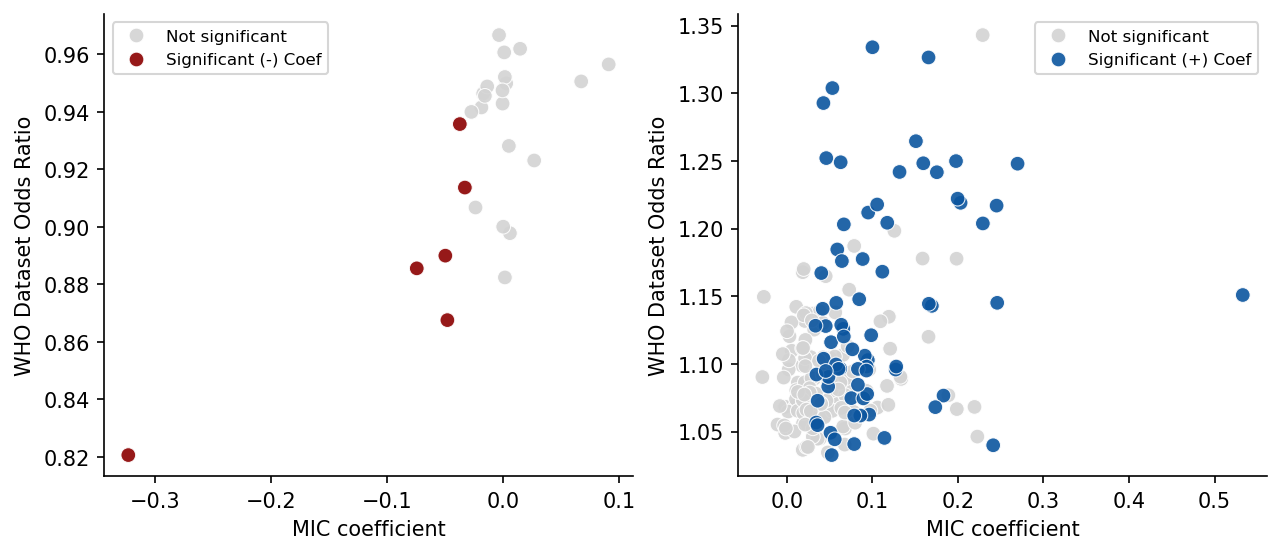

In [76]:
plot_MIC_results_with_OR(MIC_test_variants, saveName="../results/Figures/WHO_MIC_volcano_plots.svg")

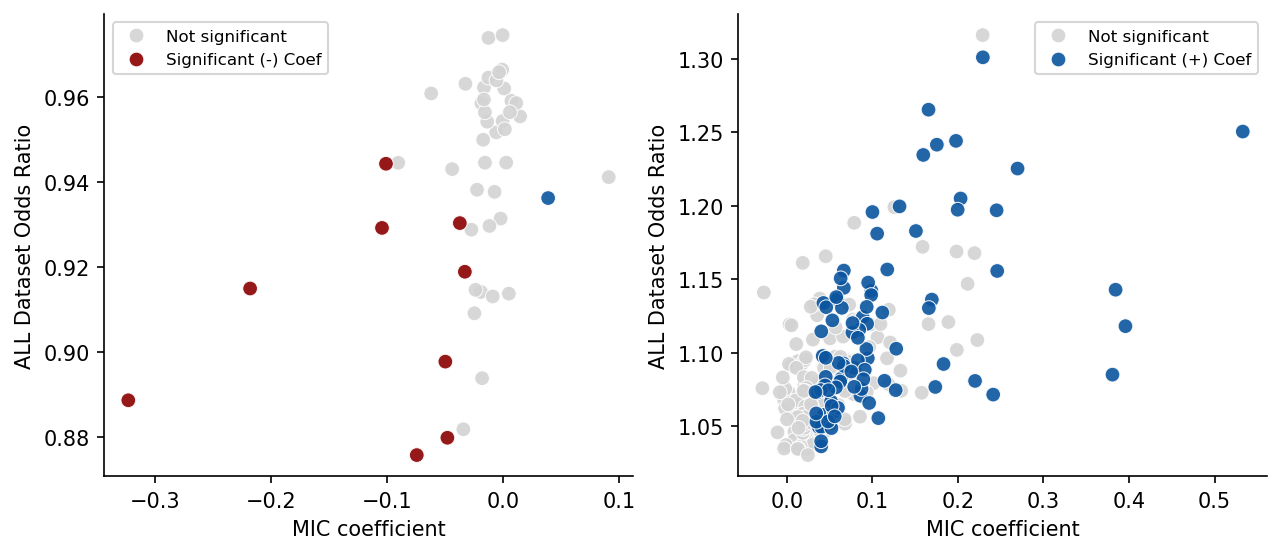

In [77]:
plot_MIC_results_with_OR(MIC_test_variants, pheno_group='ALL', saveName="../results/Figures/ALL_MIC_volcano_plots.svg")

In [65]:
# MIC says positive, WHO says negative
MIC_test_variants.query("MIC_coef > 0 & MIC_BH_pval <= 0.05 & WHO_Odds_Ratio < 1 & WHO_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,WHO_Odds_Ratio,WHO_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [82]:
# MIC says positive, ALL says negative
MIC_test_variants.query("MIC_coef > 0 & MIC_BH_pval <= 0.01 & ALL_Odds_Ratio < 1 & ALL_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [77]:
who_variants.query("variant=='gyrA_p.Arg252Leu' & drug=='Moxifloxacin'")[['ALL_Present_SOLO_R', 'ALL_Present_SOLO_S', 'WHO_Present_SOLO_R', 'WHO_Present_SOLO_S', 'INITIAL CONFIDENCE GRADING', 'FINAL CONFIDENCE GRADING', 'Additional grading criteria applied']]

,ALL_Present_SOLO_R,ALL_Present_SOLO_S,WHO_Present_SOLO_R,WHO_Present_SOLO_S,INITIAL CONFIDENCE GRADING,FINAL CONFIDENCE GRADING,Additional grading criteria applied
16111,0.0,69.0,0.0,24.0,3) Uncertain significance,3) Uncertain significance,NaN


In [83]:
results_final.query("mutation=='gyrA_p.Arg252Leu' & Drug=='Moxifloxacin'")#[['WHO_Present_S', 'WHO_Present_R', 'ALL_Present_S', 'ALL_Present_R']]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
16903,Moxifloxacin,gyrA,gyrA_p.Arg252Leu,missense_variant,0.926307,0.022,0.155897,0.977,1.0,0.437083,...,0.0019,0.995063,0.99692,Not assoc w R,4) Not assoc w R - Interim,Upgrade to Interim,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim


In [2]:
drug = 'Moxifloxacin'
keep_single_medium = False

df_phenos = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "phenos_mic.csv"))

# first apply the media hierarchy to decide which of the measured MICs to keep for each isolate (for isolates with multiple MICs measured in different media)
df_phenos = process_multiple_MICs_different_media(df_phenos)

# then, drop any media that can't be normalized and normalize to the scale of the most common medium
df_phenos, most_common_medium = normalize_MICs_return_dataframe(drug, df_phenos, cc_df, keep_single_medium=keep_single_medium)

# normalized column name
mic_col = 'norm_MIC'
    
print(f"    Min MIC: {np.min(df_phenos[mic_col].values)}, Max MIC: {np.max(df_phenos[mic_col].values)} in {most_common_medium}")

    Dropped 97/12740 isolates in ['7H9', 'Frozen Broth Microdilution Plate (PMID31969421)', 'REMA', 'M24 BMD'] without critical concentrations
    Min MIC: 0.03, Max MIC: 20.0 in UKMYC5


In [54]:
model_matrix = pd.read_pickle(os.path.join(analysis_dir, "Moxifloxacin", "MIC/tiers=1/dropAF_noSyn_unpooled", "model_matrix.pkl"))

In [55]:
df_genos = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "genos_1.csv.gz"), compression='gzip', usecols=['sample_id', 'resolved_symbol', 'variant_category', 'variant_allele_frequency']).query("sample_id in @model_matrix.index.values")

In [57]:
gene = 'gyrA'
variant = 'p.Arg252Leu'

samples_with_var = df_genos.query("resolved_symbol==@gene & variant_category == @variant & variant_allele_frequency > 0.75").sample_id.unique()
len(samples_with_var)

40

In [58]:
df_phenos.query("sample_id not in @samples_with_var")['norm_MIC'].mean(), df_phenos.query("sample_id in @samples_with_var")['norm_MIC'].mean()

(0.7310021423470602, 0.253125)

In [7]:
df_genos.query("sample_id in @samples_with_var & ~(resolved_symbol == @gene & variant_category == @variant) & variant_allele_frequency > 0.75")[['resolved_symbol', 'variant_category']].value_counts()

resolved_symbol  variant_category
gyrA             p.Glu21Gln          40
                 p.Gly668Asp         40
                 p.Ser95Thr          40
                 p.Ala90Val           2
                 p.Asp94Tyr           2
                 c.2115C>T            1
gyrB             p.Lys404Arg          1
Name: count, dtype: int64

In [25]:
df_genos.query("sample_id in @samples_with_var & resolved_symbol=='gyrA' & variant_category=='p.Ala90Val' & variant_allele_frequency > 0.75")

,sample_id,resolved_symbol,variant_category,variant_allele_frequency
40115093,28150,gyrA,p.Ala90Val,0.98
40136183,27178,gyrA,p.Ala90Val,1.00


In [14]:
samples_with_Group12_variants = df_genos.query("sample_id in @samples_with_var & resolved_symbol == 'gyrA' & variant_category in ['p.Ala90Val', 'p.Asp94Tyr'] & variant_allele_frequency > 0.75").sample_id.unique()

len(samples_with_Group12_variants)

4

In [17]:
df_phenos.query("sample_id in @samples_with_Group12_variants")['norm_MIC'].mean(), df_phenos.query("sample_id in @samples_with_var & sample_id not in @samples_with_Group12_variants")['norm_MIC'].mean()

(0.8512500000000001, 0.18666666666666665)

In [20]:
cc_df.query("Medium in ['UKMYC5', 'UKMYC6'] & Drug=='Moxifloxacin'")

,Medium,Value,Drug
12,UKMYC5,1.0,Moxifloxacin
13,UKMYC6,1.0,Moxifloxacin


In [22]:
R_samples_with_var = df_phenos.query("sample_id in @samples_with_var & norm_MIC > 1").sample_id.unique()
len(R_samples_with_var)

2

In [24]:
df_genos.query("sample_id in @R_samples_with_var & ~(resolved_symbol == @gene & variant_category == @variant) & variant_allele_frequency > 0.75")[['resolved_symbol', 'variant_category']].value_counts()

resolved_symbol  variant_category
gyrA             p.Asp94Tyr          2
                 p.Glu21Gln          2
                 p.Gly668Asp         2
                 p.Ser95Thr          2
Name: count, dtype: int64

In [26]:
df_phenos.query("sample_id in [28150, 27178]")

,sample_id,medium,MIC_lower,MIC_upper,Lower_bracket,Upper_bracket,mic_value,medium_CC,norm_medium,norm_MIC
9714,28150,UKMYC5,0.00,0.06,(,],0.030,1.0,UKMYC5,0.030
11160,27178,UKMYC5,0.25,0.50,(,],0.375,1.0,UKMYC5,0.375


In [33]:
os.path.join(analysis_dir, "Moxifloxacin", "MIC/tiers=1/dropAF_noSyn_unpooled")

'/n/data1/hms/dbmi/farhat/Sanjana/who-mutation-catalogue/Moxifloxacin/MIC/tiers=1/dropAF_noSyn_unpooled'

In [84]:
coef_df = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "MIC/tiers=1/dropAF_noSyn_unpooled", "regression_coef.csv"))
permutation_results = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "MIC/tiers=1/dropAF_noSyn_unpooled", "coef_permutation.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, "Moxifloxacin", "MIC/tiers=1/dropAF_noSyn_unpooled", "model_analysis.csv"))

In [68]:
MIC_results.query("mutation in ['gyrA_p.Arg252Leu', 'gyrA_p.Ser95Thr', 'gyrA_p.Glu21Gln', 'gyrA_p.Gly668Asp'] & Drug=='Moxifloxacin'")

,Drug,mutation,MIC_coef,MIC_BH_pval
7821,Moxifloxacin,gyrA_p.Ser95Thr,-0.181154,0.000000
8420,Moxifloxacin,gyrA_p.Glu21Gln,0.007602,0.488300
8598,Moxifloxacin,gyrA_p.Arg252Leu,0.038985,0.039538
8611,Moxifloxacin,gyrA_p.Gly668Asp,0.106308,0.000000


In [89]:
test_stat = coef_df.query("mutation=='gyrA_p.Arg252Leu'")['coef'].values[0]
np.mean(permutation_results['gyrA_p.Arg252Leu'] >= test_stat)

0.003

In [90]:
model_analysis.query("mutation=='gyrA_p.Arg252Leu'")

,mutation,coef,pval,neutral_pval,BH_pval,Bonferroni_pval,BH_neutral_pval,Bonferroni_neutral_pval
26,gyrA_p.Arg252Leu,0.038985,0.003,0.992,0.039538,1.0,1.0,1.0


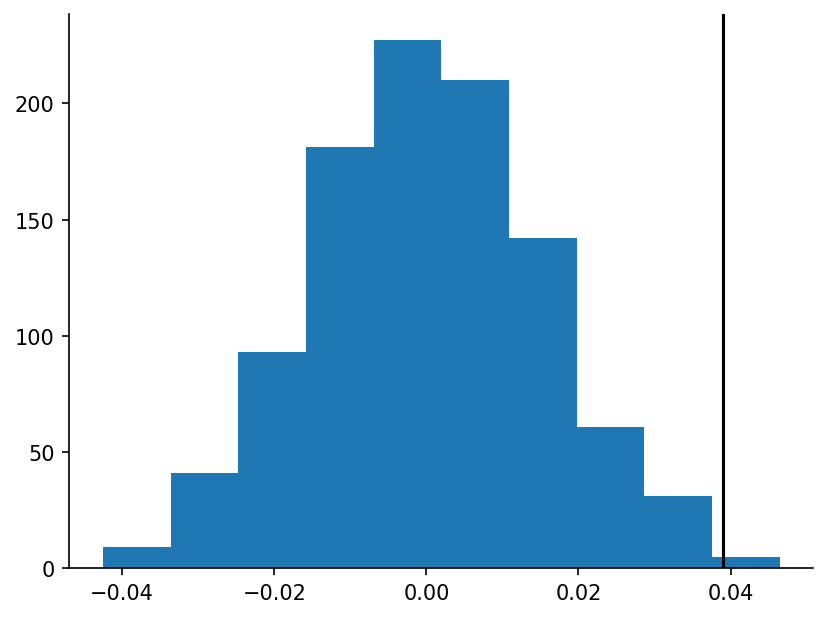

In [91]:
plt.hist(permutation_results['gyrA_p.Arg252Leu'])
plt.axvline(x=test_stat, color='black')
sns.despine()
plt.show()

In [11]:
results_final.query("mutation in ['gyrA_p.Ala90Val', 'gyrA_p.Asp94Tyr', 'gyrA_c.2115C>T', 'gyrB_p.Lys404Arg'] & Drug=='Moxifloxacin'")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,ALL_Sens_UB,ALL_Spec_LB,ALL_Spec_UB,Initial confidence grading ALL dataset,REGRESSION FINAL CONFIDENCE GRADING,Reason,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES
15699,Moxifloxacin,gyrA,gyrA_p.Ala90Val,missense_variant,2.367385,0.000,0.00000,1.000,1.000000,1.688263e-264,...,0.198527,0.972574,0.977125,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R
15702,Moxifloxacin,gyrA,gyrA_p.Asp94Tyr,missense_variant,1.622636,0.000,0.00000,1.000,1.000000,7.407323e-124,...,0.052644,0.997008,0.998416,Assoc w R,1) Assoc w R,Both Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R,1) Assoc w R
15849,Moxifloxacin,gyrB,gyrB_p.Lys404Arg,missense_variant,1.017078,0.282,0.75571,0.062,0.117429,7.020052e-01,...,0.001465,0.999700,0.999999,Uncertain,3) Uncertain significance,Both Uncertain,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance,3) Uncertain significance
15973,Moxifloxacin,gyrA,gyrA_c.2115C>T,synonymous_variant,NaN,NaN,NaN,NaN,NaN,NaN,...,0.000971,0.999700,0.999999,Uncertain,3) Uncertain significance,ALL Evidence Only,3) Uncertain significance,4) Not assoc w R - Interim,3) Uncertain significance,4) Not assoc w R - Interim


In [47]:
MIC_results = pd.read_csv("../tables/MIC_results.csv")

In [64]:
MIC_results.query("mutation=='gyrA_p.Ser95Thr'")

,Drug,mutation,MIC_coef,MIC_BH_pval
6762,Levofloxacin,gyrA_p.Ser95Thr,-0.387734,0.0
7821,Moxifloxacin,gyrA_p.Ser95Thr,-0.181154,0.0


In [65]:
MIC_results.query("mutation.str.contains(@variant)")

,Drug,mutation,MIC_coef,MIC_BH_pval
7495,Levofloxacin,gyrA_p.Arg252Leu,0.031041,0.304138
8598,Moxifloxacin,gyrA_p.Arg252Leu,0.038985,0.039538


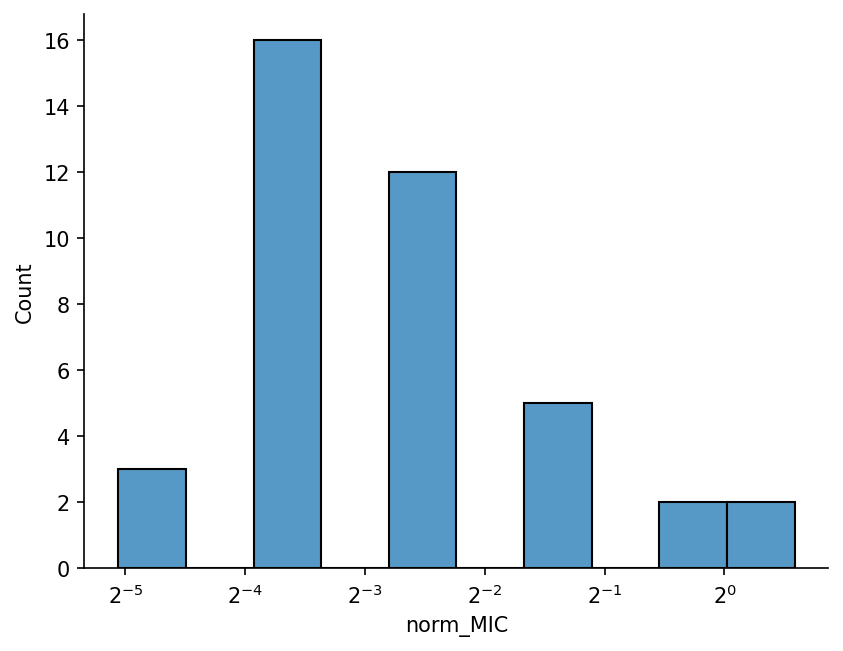

In [92]:
sns.histplot(data=df_phenos.query("sample_id in @samples_with_var"),
             x='norm_MIC',
             log_scale=2
            )

sns.despine()
plt.show()

In [68]:
# MIC says negative, WHO says positive
MIC_test_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05 & WHO_Odds_Ratio > 1 & WHO_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,WHO_Odds_Ratio,WHO_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [71]:
# MIC says negative, ALL says positive
MIC_test_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05 & ALL_Odds_Ratio > 1 & ALL_BH_pval <= 0.05")[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'Initial confidence grading WHO dataset', 'Initial confidence grading ALL dataset']]

,Drug,mutation,REGRESSION FINAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,Initial confidence grading WHO dataset,Initial confidence grading ALL dataset


In [72]:
search_df.query("Drug=='Rifampicin'").loc[(search_df['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (search_df['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')][['mutation', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'WHO_Present_R', 'WHO_Present_S', 'ALL_Present_R', 'ALL_Present_S', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING', 'MIC_coef', 'MIC_BH_pval']]

,mutation,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,WHO_Present_R,WHO_Present_S,ALL_Present_R,ALL_Present_S,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,MIC_coef,MIC_BH_pval
245,rpoB_p.Ile491Leu,1.110592,0.0,0.000030,10.0,0.0,31.0,0.0,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,0.106049,0.059000
249,rpoB_p.Phe424Val,1.091410,0.0,0.000793,14.0,0.0,18.0,0.0,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,0.072260,0.408000
250,rpoB_p.Ser493Leu,1.090062,0.0,0.000047,13.0,0.0,17.0,0.0,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,0.051408,0.585611
255,rpoB_p.Ile491Met,1.074202,0.0,0.000005,13.0,0.0,17.0,2.0,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,0.042541,0.580432
258,rpoB_p.Ile491Thr,1.064930,0.0,0.029034,7.0,0.0,9.0,0.0,1) Assoc w R,3) Uncertain significance,3) Uncertain significance,0.001667,0.585611


# Lineage Distributions for Group 3 Mutations by SOLO + GR that are Graded R-assoc by Regression

In [56]:
regression_upgrades = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')]
print(f"{len(regression_upgrades)} variants across {regression_upgrades.Drug.nunique()} drugs are graded Groups 1-2 by regression and Group 3 by SOLO + GR")

lineages_isolates_with_new_muts = pd.read_csv("../lineages/isolates_with_new_muts.csv")

# assert len(set(regression_upgrades.mutation).symmetric_difference(lineages_isolates_with_new_muts.mutation)) == 0
assert len(set(regression_upgrades.mutation) - set(lineages_isolates_with_new_muts.mutation)) == 0

# combine with gradings
lineages_isolates_with_new_muts = lineages_isolates_with_new_muts.merge(regression_upgrades[['Drug', 'mutation', 'REGRESSION FINAL CONFIDENCE GRADING']].rename(columns={'REGRESSION FINAL CONFIDENCE GRADING': 'confidence'}), on=['Drug', 'mutation'])

221 variants across 12 drugs are graded Groups 1-2 by regression and Group 3 by SOLO + GR


In [43]:
results_final.loc[(~results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')) & (results_final['REGRESSION GRADING + LOF UPGRADE'].str.contains('Assoc w R')) & (results_final['SOLO FINAL CONFIDENCE GRADING']=='3) Uncertain significance')].shape

(36, 66)

In [51]:
results_final.query("mutation=='mshA_LoF'")[['ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_BH_LRT_pval', 'WHO_Present_R', 'WHO_Present_S', 'ALL_Present_R', 'ALL_Present_S', 'ALL_R_PPV_LB', 'ALL_R_PPV', 'WHO_R_PPV_LB', 'WHO_R_PPV']]

,ALL_Odds_Ratio,ALL_BH_pval,ALL_BH_LRT_pval,WHO_Present_R,WHO_Present_S,ALL_Present_R,ALL_Present_S,ALL_R_PPV_LB,ALL_R_PPV,WHO_R_PPV_LB,WHO_R_PPV
8800,1.07468,0.0,0.000034,8.0,7.0,26.0,23.0,0.382731,0.530612,0.265861,0.533333


In [57]:
def get_new_mutations_lineage_counts(drug, lineages_isolates_with_new_muts, resistant=True, lineage_col='Coll2014'):

    single_drug_df = lineages_isolates_with_new_muts.query("Drug==@drug")
    
    # group lineage counts by both mutation and phenotype
    if resistant:
        single_drug_df = pd.DataFrame(single_drug_df.query("confidence.str.contains('Assoc w R')").groupby(['mutation', 'phenotype'])[lineage_col].value_counts()).reset_index()
    else:
        single_drug_df = pd.DataFrame(single_drug_df.query("confidence.str.contains('Not assoc w R')").groupby(['mutation', 'phenotype'])[lineage_col].value_counts()).reset_index()

    # remove multi-lineage instances
    single_drug_df = single_drug_df.query(f"~{lineage_col}.str.contains(',')")

    # create additional rows for (mutation, phenotype) combinations that are not present. i.e. if all L2.1.1 isolates are RIF-R, create a row of 0 for L2.2.1 + RIF-S
    for lineage in single_drug_df[lineage_col].unique():
    
        for mutation in single_drug_df.mutation.unique():
    
            for phenotype in [0, 1]:
                
                if len(single_drug_df.query(f"mutation==@mutation & {lineage_col}==@lineage & phenotype==@phenotype")) == 0:
                    
                    single_drug_df = pd.concat([single_drug_df, pd.DataFrame({'mutation': mutation,
                                                                                            'phenotype': phenotype,
                                                                                            lineage_col: lineage,
                                                                                            'count': 0
                                                                                           }, index=[0])]).reset_index(drop=True)
    
    # check that the dataframe is exhaustive of all the groups now
    assert len(single_drug_df) == single_drug_df.mutation.nunique() * single_drug_df.phenotype.nunique() * single_drug_df[lineage_col].nunique()
    
    # sort for plotting
    return single_drug_df.sort_values(['mutation', lineage_col, 'phenotype'])

In [58]:
def plot_heatmap_new_mutations(drug, resistant=True, lineage_col='Coll2014', saveName=None):

    single_drug_df = get_new_mutations_lineage_counts(drug, lineages_isolates_with_new_muts, resistant=resistant, lineage_col=lineage_col)

    # for readability, plot only the 10 most common mutations
    # for INH, exclude ahpC promoter mutations as they are already known to be relevant for resistance
    plot_mutations = pd.DataFrame(single_drug_df.groupby('mutation')['count'].sum()).query("~mutation.str.startswith('ahpC_c.')").sort_values('count', ascending=False).index.values[:10]

    matrix = single_drug_df.query("mutation in @plot_mutations").pivot(index=lineage_col, columns=['mutation', 'phenotype'], values='count')

    # use 1 inch per subplot
    color_maps = ['Blues', 'Reds']

    # don't share axes because need to set the axis ticks and labels only for certain subplot but not all
    fig, axs = plt.subplots(1, matrix.shape[1], figsize=(matrix.shape[1]*0.7, matrix.shape[0]*0.25), sharex=False, sharey=False)

    # normalize the color by the total number of isolates in the entire heatmap
    # vmax = matrix.values.max()
    # max_R = matrix.loc[:, matrix.columns.get_level_values(1) == 1].values.max()
    # max_S = matrix.loc[:, matrix.columns.get_level_values(1) == 0].values.max()
    
    mutations_lst = matrix.columns.get_level_values(0)
    
    for col_idx, ax in enumerate(axs):
    
        vals_to_plot = matrix.loc[:, matrix.columns[col_idx]].values

        # # odd numbered plots are resistant, even is susceptible
        # if col_idx % 2 == 0:
        #     vmax = max_S
        # else:
        #     vmax = max_R

        # normalize the color by the total number of isolates for a given mutation
        # get the first value in the column names (mutation, phenotype)
        vmax = matrix.loc[:, matrix.columns.get_level_values(0) == matrix.columns[col_idx][0]].values.max()
        
        sns.heatmap(vals_to_plot.reshape(-1, 1), 
                    ax=ax, 
                    annot=True,
                    fmt='d',
                    vmin=0,
                    vmax=vmax,
                    annot_kws={'fontsize': 7},
                    linewidth=0.25, 
                    linecolor='black',
                    cmap=color_maps[col_idx % len(color_maps)], 
                    cbar=False
                   )
    
        # remove horizontal space between columns (mutations)
        plt.subplots_adjust(wspace=0)
    
        if col_idx != 0:
            # turn off y axes for all except the first plot
            ax.get_yaxis().set_visible(False)
        else:
            ax.set_yticklabels(labels=matrix.index.values, fontsize=7, rotation=0)

        # label every other plot so that each mutation name is only listed once
        if col_idx % 2 == 0:
            ax.set_xticks([1])
            ax.set_xticklabels(labels=[mutations_lst[col_idx]], fontsize=7)
        else:
            ax.set_xticks([])

    # plt.title(f"Lineage and Phenotypic Breakdown of New Mutations for {drug}")
    sns.despine(top=False, right=False, left=False, bottom=False)

    if saveName is not None:
        plt.savefig(saveName, format='svg', bbox_inches='tight')
        plt.close()
    else:
        plt.show()

In [59]:
plot_heatmap_new_mutations('Rifampicin', resistant=True, saveName='../results/Figures/S6_RIF.svg')

In [60]:
plot_heatmap_new_mutations('Isoniazid', resistant=True, saveName='../results/Figures/S6_INH.svg')

In [61]:
plot_heatmap_new_mutations('Moxifloxacin', resistant=True, saveName='../results/Figures/S6_MXF.svg')

In [62]:
plot_heatmap_new_mutations('Levofloxacin', resistant=True, saveName='../results/Figures/S6_LFX.svg')

In [63]:
plot_heatmap_new_mutations('Ethambutol', resistant=True, saveName='../results/Figures/S6_EMB.svg')

In [64]:
plot_heatmap_new_mutations('Ethionamide', resistant=True, saveName='../results/Figures/S6_ETO.svg')

In [65]:
plot_heatmap_new_mutations('Pyrazinamide', resistant=True, saveName='../results/Figures/S6_PZA.svg')

In [66]:
plot_heatmap_new_mutations('Streptomycin', resistant=True, saveName='../results/Figures/S6_STM.svg')

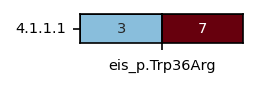

In [67]:
plot_heatmap_new_mutations('Amikacin', resistant=True)

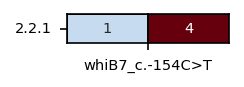

In [68]:
plot_heatmap_new_mutations('Kanamycin', resistant=True)

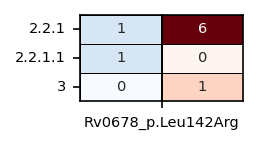

In [69]:
plot_heatmap_new_mutations('Bedaquiline', resistant=True)

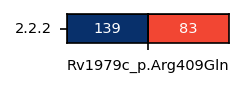

In [70]:
plot_heatmap_new_mutations('Clofazimine', resistant=True)

In [ ]:
# nothing for these
# plot_heatmap_new_mutations('Capreomycin', resistant=True)
# plot_heatmap_new_mutations('Delamanid', resistant=True)

In [29]:
# lineage_new_muts_supplement_df = []
# resistant = True
# lineage_col = 'Coll2014'

# for drug in regression_upgrades.Drug.unique():

#     single_drug_df = get_new_mutations_lineage_counts(drug, lineages_isolates_with_new_muts, resistant=resistant, lineage_col=lineage_col)
#     single_drug_df['Drug'] = drug
#     lineage_new_muts_supplement_df.append(single_drug_df)

# lineage_new_muts_supplement_df = pd.concat(lineage_new_muts_supplement_df)
# lineage_new_muts_supplement_df = lineage_new_muts_supplement_df.query("count > 0")
# lineage_new_muts_supplement_df['Lineage'] = lineage_new_muts_supplement_df['Coll2014'].str[0]
# bovis, canettii, etc.
# lineage_new_muts_supplement_df.loc[lineage_new_muts_supplement_df['Lineage'].str.isalpha(), 'Lineage'] = lineage_new_muts_supplement_df['Coll2014']
# lineage_new_muts_supplement_df[['Drug', 'mutation', 'phenotype', 'Coll2014', 'count']].to_csv("../tables/lineage_dist_regression_upgrades.csv", index=False)

In [36]:
lineage_new_muts_supplement_df = pd.read_csv("../tables/lineage_dist_regression_upgrades.csv")
np.sort(lineage_new_muts_supplement_df.Lineage.unique())

array(['1', '2', '3', '4', '5', 'BOV_AFRI'], dtype=object)

In [37]:
lineage_new_muts_supplement_df[['Drug', 'mutation']].drop_duplicates().shape

(221, 2)

# Summary Information on the Lineage Distributions for the Regression Upgrades

In [44]:
lineage_col = 'Lineage'

df_new_lineage_summary = pd.DataFrame(lineage_new_muts_supplement_df.groupby(['Drug', 'mutation'])[lineage_col].nunique()).reset_index()
len(df_new_lineage_summary)

221

In [45]:
len(df_new_lineage_summary.query(f"{lineage_col} == 1")), len(df_new_lineage_summary.query(f"{lineage_col} > 1"))

(44, 177)

In [59]:
177/221

0.8009049773755657

In [46]:
lineage_restricted_variants = df_new_lineage_summary.query(f"{lineage_col}==1")[['Drug', 'mutation']]

In [47]:
lineage_restricted_variants_counts = pd.DataFrame(lineage_new_muts_supplement_df.merge(lineage_restricted_variants, on=['Drug', 'mutation']).groupby(['Drug', 'mutation'])['count'].sum()).reset_index()

lineage_restricted_variants_counts[['Drug', 'mutation']].drop_duplicates().shape

(44, 2)

In [51]:
lineage_new_muts_supplement_df.query("mutation=='eis_p.Trp36Arg'")

,Drug,mutation,phenotype,Coll2014,count,Lineage
0,Amikacin,eis_p.Trp36Arg,0,4.1.1.1,3,4
1,Amikacin,eis_p.Trp36Arg,1,4.1.1.1,7,4


In [61]:
lineage_restricted_variants_counts.query("count < 10")[['Drug', 'mutation']].drop_duplicates().shape, lineage_restricted_variants_counts.query("count >= 10")[['Drug', 'mutation']].drop_duplicates().shape

((18, 2), (26, 2))

In [57]:
pd.DataFrame(lineage_new_muts_supplement_df.merge(lineage_restricted_variants, on=['Drug', 'mutation']).groupby(['Drug', 'mutation'])['Coll2014'].unique()).reset_index()

,Drug,mutation,Coll2014
0,Amikacin,eis_p.Trp36Arg,[4.1.1.1]
1,Clofazimine,Rv1979c_p.Arg409Gln,[2.2.2]
2,Ethambutol,embA_p.Thr608Asn,[4.6.1.2]
3,Ethambutol,embB_p.Asn296His,[2.2.1]
4,Ethambutol,embB_p.Val456Ala,[2.2.1.1]
5,Ethambutol,embC_c.-10A>C,[4.1.2.1]
6,Ethambutol,embC_c.-531C>T,[2.2.1]
7,Ethambutol,embC_c.-632G>A,[2.2.1]
8,Ethambutol,ubiA_p.Leu31Pro,"[4.1.2.1, 4.2.1, 4.3.3, 4.3.4.1, 4.5, 4.7, 4.8]"
9,Ethambutol,ubiA_p.Phe238Cys,"[4.1.2.1, 4.4.1.1]"


# S-Associated Variants: only describe those with MIC evidence also in the paper

In [174]:
S_assoc_variants = results_final.loc[(results_final['REGRESSION FINAL CONFIDENCE GRADING'].str.contains('Not assoc')) & (results_final['Initial confidence grading WHO dataset'] != 'Neutral')& (results_final['Initial confidence grading ALL dataset'] != 'Neutral')].reset_index(drop=True)

S_assoc_variants = S_assoc_variants.merge(MIC_results, on=['Drug', 'mutation'], how='left')

S_assoc_variants = S_assoc_variants.merge(who_variants[['drug', 'variant', 'WHO_Present_SOLO_S', 'WHO_Present_SOLO_R', 'ALL_Present_SOLO_S', 'ALL_Present_SOLO_R']].rename(columns={'drug': 'Drug', 'variant': 'mutation'}), on=['Drug', 'mutation'], how='left')

print(len(S_assoc_variants), S_assoc_variants.Drug.nunique())

132 13


In [175]:
S_assoc_variants.query("ALL_Present_SOLO_S > ALL_Present_SOLO_R | (MIC_coef < 0 & MIC_BH_pval <= 0.05)").shape

(91, 72)

In [176]:
S_assoc_variants.query("ALL_Present_SOLO_S > ALL_Present_SOLO_R & (MIC_coef < 0 & MIC_BH_pval <= 0.05)")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R
8,Bedaquiline,mmpL5,mmpL5_LoF,LoF,0.805117,0.014,0.040676,0.982,1.0,1.183522e-02,...,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.323631,0.000000,2.0,0.0,209.0,0.0
15,Clofazimine,Rv1979c,Rv1979c_c.-50A>C,upstream_gene_variant,0.929599,0.036,0.202378,0.882,1.0,1.503049e-01,...,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.064340,0.000000,3.0,0.0,52.0,0.0
29,Ethambutol,embC,embC_c.-900C>T,upstream_gene_variant,0.921245,0.025,0.226586,0.944,1.0,3.314202e-01,...,5) Not assoc w R,5) Not assoc w R,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.242851,0.000000,594.0,7.0,885.0,12.0
66,Kanamycin,whiB7,whiB7_c.-100T>C,upstream_gene_variant,0.917472,0.008,0.046596,0.987,1.0,3.229649e-01,...,5) Not assoc w R,5) Not assoc w R,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.054090,0.024316,72.0,0.0,227.0,2.0
68,Kanamycin,eis,eis_LoF,LoF,1.050366,0.030,0.164211,0.908,1.0,1.000000e+00,...,3) Uncertain significance,3) Uncertain significance,4) Not assoc w R - Interim,4) Not assoc w R - Interim,-0.108152,0.000000,40.0,5.0,158.0,5.0
82,Levofloxacin,gyrA,gyrA_p.Ser95Thr,missense_variant,0.611583,0.000,0.000000,1.000,1.0,1.435003e-17,...,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,-0.383087,0.000000,18.0,0.0,22.0,1.0
86,Moxifloxacin,gyrA,gyrA_p.Ser95Thr,missense_variant,0.717544,0.000,0.000000,1.000,1.0,2.161930e-08,...,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,5) Not assoc w R,-0.178469,0.000000,12.0,0.0,17.0,0.0


In [177]:
S_assoc_variants[['SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].value_counts()

SOLO INITIAL CONFIDENCE GRADING  SOLO FINAL CONFIDENCE GRADING
3) Uncertain significance        3) Uncertain significance        61
5) Not assoc w R                 5) Not assoc w R                 54
3) Uncertain significance        4) Not assoc w R - Interim       13
4) Not assoc w R - Interim       4) Not assoc w R - Interim        3
3) Uncertain significance        2) Assoc w R - Interim            1
Name: count, dtype: int64

In [182]:
len(S_assoc_variants)

132

In [178]:
S_assoc_variants.loc[S_assoc_variants['SOLO FINAL CONFIDENCE GRADING'].str.contains('Assoc w R')]

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R
41,Ethionamide,ethA,ethA_p.Pro209fs,frameshift,0.913251,0.001,0.003481,0.999,1.0,0.182828,...,3) Uncertain significance,2) Assoc w R - Interim,4) Not assoc w R - Interim,4) Not assoc w R - Interim,NaN,NaN,26.0,0.0,26.0,0.0


In [179]:
# number with significant MIC coefficients
S_assoc_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05").shape, S_assoc_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05").Drug.nunique()

((15, 72), 8)

In [180]:
# good, no significant positive MIC coefficients
S_assoc_variants.query("MIC_coef > 0 & MIC_BH_pval <= 0.05")

,Drug,gene,mutation,predicted_effect,WHO_Odds_Ratio,WHO_pval,WHO_BH_pval,WHO_neutral_pval,WHO_BH_neutral_pval,WHO_LRT_pval,...,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING,REGRESSION GRADING + LOF UPGRADE,REGRESSION + GRADING RULES,MIC_coef,MIC_BH_pval,WHO_Present_SOLO_S,WHO_Present_SOLO_R,ALL_Present_SOLO_S,ALL_Present_SOLO_R


In [185]:
S_assoc_variants_save = S_assoc_variants.query("MIC_coef < 0 & MIC_BH_pval <= 0.05")[['Drug', 'mutation', 'WHO_Odds_Ratio', 'WHO_BH_pval', 'ALL_Odds_Ratio', 'ALL_BH_pval', 'ALL_Present_SOLO_S', 'ALL_Present_SOLO_R', 'MIC_coef', 'REGRESSION FINAL CONFIDENCE GRADING', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].sort_values(['Drug', 'REGRESSION FINAL CONFIDENCE GRADING', 'ALL_Odds_Ratio'], ascending=[True, False, True])

print(len(S_assoc_variants_save))

S_assoc_variants_save.to_csv("../tables/S_assoc_variants.csv", index=False)

15


In [187]:
S_assoc_variants_save[['SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']].value_counts()

SOLO INITIAL CONFIDENCE GRADING  SOLO FINAL CONFIDENCE GRADING
3) Uncertain significance        3) Uncertain significance        9
5) Not assoc w R                 5) Not assoc w R                 5
3) Uncertain significance        4) Not assoc w R - Interim       1
Name: count, dtype: int64

In [191]:
S_assoc_variants_save.loc[S_assoc_variants_save['SOLO FINAL CONFIDENCE GRADING'] == '3) Uncertain significance']

,Drug,mutation,WHO_Odds_Ratio,WHO_BH_pval,ALL_Odds_Ratio,ALL_BH_pval,ALL_Present_SOLO_S,ALL_Present_SOLO_R,MIC_coef,REGRESSION FINAL CONFIDENCE GRADING,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
5,Amikacin,eis_p.His150fs,0.867707,0.000000,0.880061,0.000000,0.0,0.0,-0.047640,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance
3,Amikacin,eis_p.Met1?,0.913777,0.000000,0.919073,0.000000,0.0,0.0,-0.032858,5) Not assoc w R,3) Uncertain significance,3) Uncertain significance
1,Amikacin,eis_c.-9T>C,0.935909,0.000000,0.930504,0.000000,0.0,0.0,-0.037033,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
8,Bedaquiline,mmpL5_LoF,0.805117,0.040676,0.888159,0.000000,209.0,0.0,-0.323631,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
7,Bedaquiline,mmpL5_p.Arg202fs,0.949988,0.079258,0.914969,0.000000,0.0,0.0,-0.217665,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
15,Clofazimine,Rv1979c_c.-50A>C,0.929599,0.202378,0.906902,0.023324,52.0,0.0,-0.064340,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
74,Kanamycin,eis_p.His150fs,0.885567,0.000000,0.875896,0.000000,0.0,0.0,-0.074057,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
71,Kanamycin,eis_p.Met1?,0.889970,0.000000,0.897791,0.000000,0.0,0.0,-0.049581,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance
68,Kanamycin,eis_LoF,1.050366,0.164211,0.928993,0.000000,158.0,5.0,-0.108152,4) Not assoc w R - Interim,3) Uncertain significance,3) Uncertain significance


# Not AwR Variants from Literature

In [105]:
# keep only tier 1 variants
NotAwR_by_literature = pd.read_excel("../data/NotAwR by literature.xlsx", sheet_name='Sheet1').merge(who_variants[['drug', 'variant']], how='inner')
NotAwR_by_literature.rename(columns={'drug': 'Drug', 'variant': 'mutation'}, inplace=True)

# merge with regressionr esults
NotAwR_by_literature = results_final.merge(NotAwR_by_literature)
NotAwR_by_literature.shape

(28, 66)

In [106]:
NotAwR_by_literature['REGRESSION FINAL CONFIDENCE GRADING'].value_counts()

REGRESSION FINAL CONFIDENCE GRADING
3) Uncertain significance     27
4) Not assoc w R - Interim     1
Name: count, dtype: int64

In [111]:
NotAwR_by_literature.loc[NotAwR_by_literature['REGRESSION FINAL CONFIDENCE GRADING'] != '3) Uncertain significance'][['Drug', 'mutation', 'WHO_BH_pval', 'WHO_BH_neutral_pval', 'ALL_BH_pval', 'ALL_BH_neutral_pval']]

,Drug,mutation,WHO_BH_pval,WHO_BH_neutral_pval,ALL_BH_pval,ALL_BH_neutral_pval
22,Levofloxacin,gyrA_p.Arg252Leu,0.036119,1.0,0.785241,0.686341


# Neutral Example for Figure S3

In [32]:
thresh = 0.05
solo_neutral = who_variants.query("WHO_Neutral_masked==True").variant.values

results_final.query("WHO_BH_pval > @thresh & WHO_BH_neutral_pval <= @thresh & WHO_Present_SR >= 5 & mutation in @solo_neutral")[['Drug', 'mutation', 'SOLO INITIAL CONFIDENCE GRADING', 'SOLO FINAL CONFIDENCE GRADING']]

,Drug,mutation,SOLO INITIAL CONFIDENCE GRADING,SOLO FINAL CONFIDENCE GRADING
10195,Ethionamide,mshA_p.Asn111Ser,5) Not assoc w R,5) Not assoc w R
14175,Levofloxacin,gyrB_c.1983C>T,5) Not assoc w R,5) Not assoc w R
16881,Moxifloxacin,gyrB_c.1983C>T,5) Not assoc w R,5) Not assoc w R
16895,Moxifloxacin,gyrB_p.Val301Leu,5) Not assoc w R,5) Not assoc w R
18811,Rifampicin,rpoB_p.Ser388Leu,5) Not assoc w R,5) Not assoc w R


In [71]:
def plot_permutation_df(permute_df, coef_df, model_analysis, variant, saveName=None):

    fig, ax = plt.subplots(figsize=(4, 3))

    y_array = np.exp(permute_df[variant])
    OR = np.round(model_analysis.query("mutation==@variant")['Odds_Ratio'].values[0], 2)

    if OR == 1:
        OR = np.round(model_analysis.query("mutation==@variant")['Odds_Ratio'].values[0], 4)
    
    sns.histplot(x=y_array,
                 ax=ax,
                )
    
    plt.axvline(x=np.exp(coef_df.query("mutation==@variant")['coef'].values[0]), color='tomato', label=f'OR = {OR}')
    plt.title(f"Permuted Model ORs for {variant}", fontsize='9')
    plt.xlabel("Odds Ratio", fontsize='9')
    plt.ylabel('', fontsize='9')

    plt.xticks(fontsize='8')
    plt.yticks(ticks=[], fontsize='8')
    plt.legend(fontsize='7')
    
    sns.despine()

    if saveName is None:
        plt.show()
    else:
        plt.savefig(saveName, format='svg', bbox_inches='tight')

p-value: 0.153


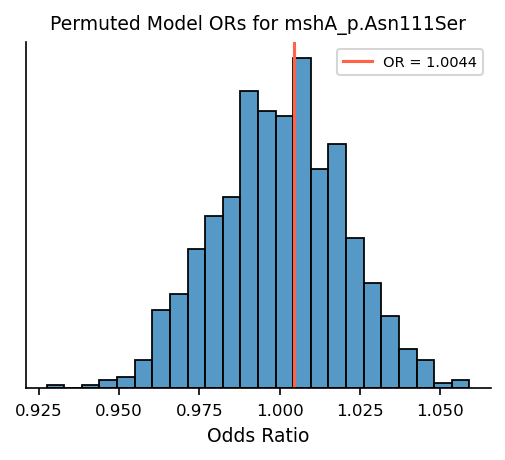

In [72]:
drug = 'Ethionamide'
model_prefix = 'dropAF_withSyn_unpooled'
model_prefix = f"BINARY/tiers=1/phenos=WHO/{model_prefix}"

permute_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "coef_permutation.csv"))
coef_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "regression_coef.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "model_analysis.csv"))

neutral_variant = 'mshA_p.Asn111Ser'
pval = model_analysis.query("mutation==@neutral_variant")['neutral_pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, neutral_variant, saveName='../results/Figures/neutral_permutation_example.svg')

p-value: 0.0


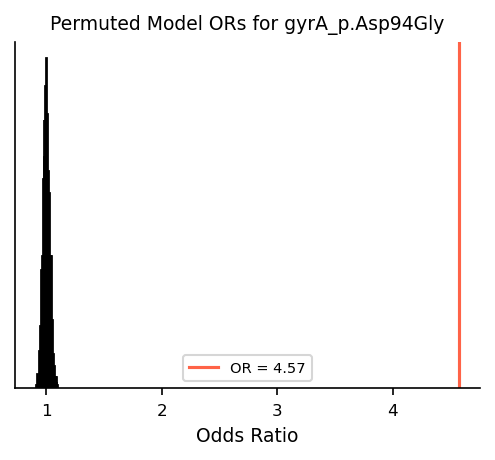

In [73]:
drug = 'Moxifloxacin'
model_prefix = 'dropAF_noSyn_unpooled'
model_prefix = f"BINARY/tiers=1/phenos=WHO/{model_prefix}"

permute_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "coef_permutation.csv"))
coef_df = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "regression_coef.csv"))
model_analysis = pd.read_csv(os.path.join(analysis_dir, drug, model_prefix, "model_analysis.csv"))

R_assoc_variant = 'gyrA_p.Asp94Gly'
# S_assoc_variant = 'gyrA_p.Ser95Thr'

pval = model_analysis.query("mutation==@R_assoc_variant")['pval'].values[0]
print(f"p-value: {pval}")
plot_permutation_df(permute_df, coef_df, model_analysis, R_assoc_variant, saveName='../results/Figures/R_assoc_permutation_example.svg')

# pval = model_analysis.query("mutation==@S_assoc_variant")['pval'].values[0]
# print(f"p-value: {pval}")
# plot_permutation_df(permute_df, coef_df, model_analysis, S_assoc_variant)#, saveName='../supplement/Figures/S_assoc_permutation.png')

# Chi-Squared Distribution (just for illustration purposes)

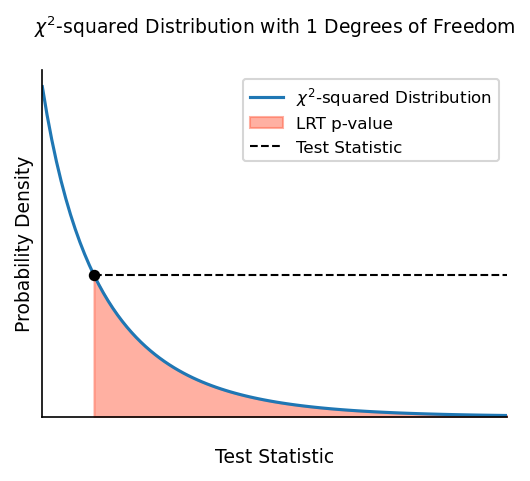

In [74]:
# Generate values for the chi-squared distribution
min_val = 1
max_val = 10
chi_stat = 2
dof = 1

fig, ax = plt.subplots(figsize=(4, 3))
x = np.linspace(min_val, max_val, 100)  # Adjust the range as needed
chi_squared_values = st.chi2.pdf(x, df=dof)

# Plot the chi-squared distribution
plt.plot(x, chi_squared_values, label=f'$\\chi^2$-squared Distribution')

# Highlight the area under the curve for the test statistic
# plt.fill_between(x, chi_squared_values, where=(x <= chi_stat), color='purple', alpha=0.5, label='LRT neutral p-value')
plt.fill_between(x, chi_squared_values, where=(x >= chi_stat), color='tomato', alpha=0.5, label='LRT p-value')
plt.hlines(y=st.chi2.pdf(chi_stat, df=dof), xmin=chi_stat, xmax=max_val, linestyle='--', linewidth=1, color='black', label='Test Statistic')
plt.scatter(x=chi_stat, y=st.chi2.pdf(chi_stat, df=dof), color='black', s=20, zorder=4)

# Add labels and legend
plt.title(f'$\\chi^2$-squared Distribution with {dof} Degrees of Freedom\n', fontsize='9')
plt.xlabel('\nTest Statistic', fontsize='9')
plt.ylabel('Probability Density', fontsize='9')
plt.legend(fontsize='8')

# Show plot
# plt.grid(True)
sns.despine()
plt.xlim(min_val, max_val)
plt.xticks(ticks=[])
plt.yticks(ticks=[])
plt.ylim(0, )
plt.savefig("../results/Figures/S3C_LRT.svg", format='svg', bbox_inches='tight')